# **ML Project 2025/2026**
### **NBA Player Development and Role Dynamics Analysis**


> **Group members:**
> - Federico Sanna (312881)
> - Arianna Di Lecce (319181)
> - Filippo Parissi (309151)





# **Court Dynamics — Project Introduction**

We are part of a research team studying **player development and role dynamics across multiple NBA seasons**.  
Using the SQLite dataset *basketball.db*, which contains player- and team-level statistics (scoring efficiency, assist ratios, defensive metrics, and historical trends), we design an **interpretable analytical framework** to understand how individual performance evolves over time and how it relates to player roles within a team context.

Rather than focusing on a single predictive outcome, we prioritize **insight-driven analysis**. Modeling techniques are used as analytical tools to uncover patterns, anomalies, and progression trajectories that can support coaches, analysts, and scouts in data-informed decision making.

---


---


## **Project Guideline (Notebook Roadmap)**

### 1) Data Loading and Understanding
- We connect to the *basketball.db* SQLite database.
- We inspect available tables, keys, and relationships.
- We construct an analysis-ready dataset at the **player–season level**, integrating team context where relevant.

### 2) Data Preprocessing
- We handle missing values using informed strategies (we analyze missing data patterns following the OSEMN framework to guide preprocessing decisions.).
- We encode categorical variables (e.g., position, team).
- We scale and transform numerical features when required.
- We identify and manage outliers, evaluating their impact on analysis and models.


### 3) Exploratory Data Analysis (EDA) and Visualization
- We analyze distributions and summary statistics of key performance metrics.
- We study temporal trends to observe player development across seasons.
- We explore relationships between variables (correlations, role indicators).

### 4) Problem Definition and Model Design
- We define the learning task (primarily **unsupervised learning for role discovery**, with possible complementary analyses).
- We split the data into training, validation, and test sets when applicable.
- We evaluate baseline behavior using default hyperparameters.
- We train **at least three different models**.
- We apply cross-validation to tune hyperparameters, clearly describing each tuned parameter.

### 5) Model Selection
- We select the best model using metrics aligned with the analytical objective (e.g., clustering quality, stability, interpretability).
- We balance quantitative performance with domain relevance.

### 6) Final Evaluation
- We evaluate the selected model on the test set only at the final stage (if applicable).
- We report final metrics and validate the robustness of results.

### 7) Model Comparison and Insights
- We compare models in terms of performance, stability, and interpretability.
- We translate results into actionable insights, highlighting:
  - player role archetypes,
  - development and progression trajectories,
  - anomalous seasons or performances,
  - implications for team composition and player development strategies

### 8) Conclusion (Summary)



---



---



## **1) Data Loading and Understanding**

In this step we load the data from the SQLite database and build the foundation for the rest of the notebook.

We are going to:
- connect to *basketball.db* and list all available tables
- inspect table schemas (columns and types) and basic row counts
- construct a first **analysis-ready dataset** at the **player–season** level by combining:
  - player season statistics (main fact table)
  - player attributes (e.g., position, height, weight, college)
  - team season context for the same year (team-level performance indicators)
  - team metadata (location/name/league when available)

The result will be a single DataFrame we will reuse in EDA and preprocessing.

### 1.1 Connecting to the SQLite database and inspecting available tables

We first connect to the SQLite database and list all available tables.
This allows us to understand the database structure and identify which tables
contain player statistics, player metadata, and team-level information.

In [415]:

import sqlite3
import numpy as np
import pandas as pd

DB_PATH = "basketball.db"

conn = sqlite3.connect(DB_PATH)

tables = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;",
    conn
)

tables

,name
0,coaches_career
1,coaches_season
2,data_dictionary
3,draft
4,player_allstar
5,player_playoffs
6,player_playoffs_career
7,player_regular_season
8,player_regular_season_career
9,players


### 1.2 Table overview: size and schema

For each table we inspect:
- the number of rows (to understand its scale),
- the number of columns,
- and a preview of column names.

This step helps us identify **fact tables** (large, season-based) versus
**dimension tables** (metadata and descriptors).

In [416]:
table_overview = []

for t in tables["name"].tolist():
    n_rows = pd.read_sql_query(f"SELECT COUNT(*) AS n FROM {t};", conn).loc[0, "n"]
    cols = pd.read_sql_query(f"PRAGMA table_info({t});", conn)[["name", "type"]]
    table_overview.append(
        {
            "table": t,
            "rows": int(n_rows),
            "n_columns": int(cols.shape[0]),
            "columns": ", ".join(cols["name"].tolist()[:25]) + (" ..." if cols.shape[0] > 25 else "")
        }
    )

pd.DataFrame(table_overview).sort_values(["rows", "table"], ascending=[False, True]).reset_index(drop=True)

,table,rows,n_columns,columns
0,player_regular_season,19157,23,"ilkid, year, firstname, lastname, team, leag, ..."
1,draft,8613,1,"draft_year,draft_round,selection,team,firstnam..."
2,player_playoffs,7578,23,"ilkid, year, firstname, lastname, team, leag, ..."
3,player_regular_season_career,3784,21,"ilkid, firstname, lastname, leag, gp, minutes,..."
4,players,3607,11,"ilkid, firstname, lastname, position, firstsea..."
5,player_playoffs_career,2075,21,"ilkid, firstname, lastname, leag, gp, minutes,..."
6,player_allstar,1474,23,"ilkid, year, firstname, lastname, conference, ..."
7,coaches_season,1261,10,"coachid, year, yr_order, firstname, lastname, ..."
8,team_season,1205,36,"team, year, leag, o_fgm, o_fga, o_ftm, o_fta, ..."
9,coaches_career,269,7,"coachid, firstname, lastname, season_win, seas..."


### 1.3 Loading core tables into DataFrames

We now load the core tables needed for player–season analysis:

- *player_regular_season*: main fact table with individual performance per season
- *players*: static player attributes
- *team_season*: team-level statistics per season
- *teams*: team metadata (location, name, league)

Keeping these tables separate at first allows us to validate keys and consistency
before merging.

In [417]:
players = pd.read_sql_query(
    """
    SELECT ilkid, position, firstseason, lastseason,
           h_feet, h_inches, weight, college, birthdate
    FROM players
    """,
    conn
)

prs = pd.read_sql_query(
    "SELECT * FROM player_regular_season",
    conn
)

team_season = pd.read_sql_query(
    "SELECT * FROM team_season",
    conn
)

teams = pd.read_sql_query(
    "SELECT team, location, name, leag FROM teams",
    conn
)

players.shape, prs.shape, team_season.shape, teams.shape

((3607, 9), (19157, 23), (1205, 36), (108, 4))

### 1.4 Preparing team-level tables for merging

Before merging, we explicitly rename team-related columns.

Why we do this:
- Player statistics and team statistics often share column names
  (e.g. *wins*, *losses*, *pts*).
- Renaming team-level variables with a *team_* prefix to avoid ambiguity, improves readability, and prevents silent overwrites during merges.

In [418]:
team_season_renamed = team_season.copy()

rename_map = {
    c: f"team_{c}"
    for c in team_season_renamed.columns
    if c not in ["team", "year"]
}

team_season_renamed = team_season_renamed.rename(columns=rename_map)

teams_renamed = teams.rename(
    columns={
        "location": "team_location",
        "name": "team_name",
        "leag": "team_leag_meta"
    }
)

### 1.5 Constructing the player–season analysis dataset

We now merge all tables into a single DataFrame.

Merge logic:
- *player_regular_season* is the **base table** (one row per player per season)
- Player attributes are joined using the unique player identifier (*ilkid*)
- Team seasonal performance is joined using (*team*, *year*)
- Team metadata is joined using the team identifier

We use **left joins** to ensure no player-season observations are lost.

In [419]:
df_player_season = (
    prs.merge(players, on="ilkid", how="left", suffixes=("", "_player"))
       .merge(team_season_renamed, on=["team", "year"], how="left")
       .merge(teams_renamed, on="team", how="left")
)

df_player_season.shape

(22866, 68)

### 1.6 Initial inspection of the analysis dataset

We conclude this step with a quick inspection of:
- the first rows,
- data types,
- and key identifying columns.

This confirms that the dataset is correctly structured and ready for
exploratory data analysis.

In [420]:
df_player_season.head()

,ilkid,year,firstname,lastname,team,leag,gp,minutes,pts,oreb,...,team_d_blk,team_d_3pm,team_d_3pa,team_d_pts,team_pace,team_won,team_lost,team_location,team_name,team_leag_meta
0,RATKOGE01,1952,George,Ratkovicz,MI1,N,71.0,NaN,678.0,0.0,...,0.0,NaN,0.0,5595.0,NaN,27.0,44.0,Milwaukee,Hawks,N
1,MOHAMNA01,1999,Nazr,Mohammed,PHI,N,NaN,NaN,54.0,16.0,...,NaN,417.0,1172.0,7661.0,95.176979,49.0,33.0,Philadelphia,76ers,N
2,CLARKKE01,1998,Keon,Clark,DEN,N,28.0,409.0,93.0,36.0,...,NaN,237.0,0.0,5004.0,92.687073,14.0,36.0,Denver,Rockets,A
3,CLARKKE01,1998,Keon,Clark,DEN,N,28.0,409.0,93.0,36.0,...,NaN,237.0,0.0,5004.0,92.687073,14.0,36.0,Denver,Nuggets,N
4,BLAYLMO01,2000,Mookie,Blaylock,GSW,N,69.0,2352.0,760.0,71.0,...,493.0,439.0,1159.0,8326.0,95.863075,17.0,65.0,Golden State,Warriors,N


In [421]:
df_player_season.dtypes.value_counts()

,count
float64,55
object,12
int64,1


In [422]:
df_player_season[["ilkid", "year", "team", "firstname", "lastname", "position"]].head(10)

,ilkid,year,team,firstname,lastname,position
0,RATKOGE01,1952,MI1,George,Ratkovicz,F
1,MOHAMNA01,1999,PHI,Nazr,Mohammed,C
2,CLARKKE01,1998,DEN,Keon,Clark,C
3,CLARKKE01,1998,DEN,Keon,Clark,C
4,BLAYLMO01,2000,GSW,Mookie,Blaylock,G
5,PERSOWE01,1997,CLE,Wesley,Person,G
6,RUSSEBI01,1958,BOS,Bill,Russell,C
7,ROLLITR01,1983,ATL,Tree,Rollins,C
8,HENDETO01,1975,ATL,Tom,Henderson,G
9,THIRDDA01,1985,BOS,David,Thirdkill,F




---



---



## **2) Data Preprocessing**

In this step we prepare the dataset for exploratory analysis and modeling by
systematically cleaning and transforming the data.

Following the **OSEMN framework** (Scrub phase in particular), our objectives are:
- to understand and handle missing values in a principled way,
- to encode categorical variables so they can be used by models,
- to scale numerical features when required,
- and to identify and manage outliers that could distort patterns or model behavior.

All preprocessing choices are motivated by data inspection and by the need to
preserve interpretability, rather than blindly optimizing performance.

### 2.1 Inspecting missing values (global overview)

We start by quantifying missing values across all columns.
This allows us to:
- identify which variables are affected,
- assess the proportion of missingness,
- and decide whether missing values are negligible, informative, or problematic.

According to the OSEMN framework, we never impute before understanding the
missingness pattern.  

In [423]:
missing_summary = (
    df_player_season
    .isna()
    .sum()
    .sort_values(ascending=False)
)

missing_summary.head(20)

,0
team_o_pf,3693
team_o_oreb,3660
team_d_pf,3649
team_o_reb,3645
team_pace,3643
team_d_3pm,3638
team_d_stl,3633
team_o_blk,3629
team_d_ftm,3629
team_o_fga,3619


### 2.1 **GRAPH**: Missing values before preprocessing

We visualize missingness before any preprocessing to understand:
- which columns contain missing values,
- how much is missing,
- and whether missingness appears structured (patterns) or random.



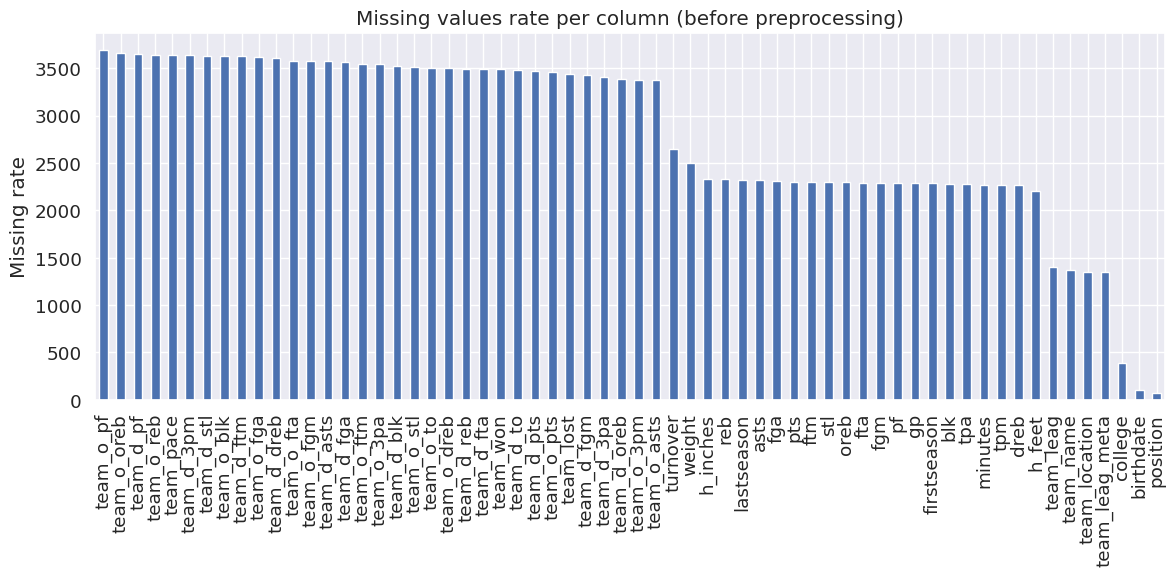

In [424]:
import matplotlib.pyplot as plt

missing_rate_before = df_player_season.isna().sum().sort_values(ascending=False)
missing_rate_before = missing_rate_before[missing_rate_before > 0]

plt.figure(figsize=(12, 6))
missing_rate_before.plot(kind="bar")
plt.ylabel("Missing rate")
plt.title("Missing values rate per column (before preprocessing)")
plt.tight_layout()
plt.show()

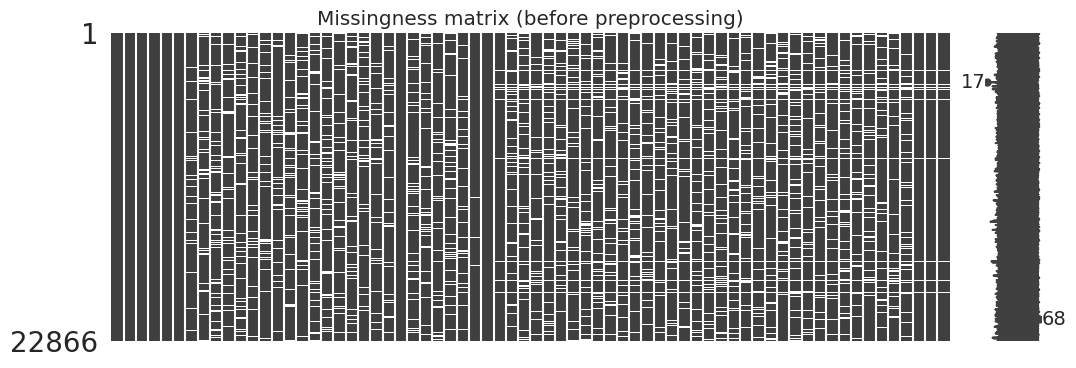

In [425]:
import missingno as msno
msno.matrix(df_player_season, figsize=(12, 4))
plt.title("Missingness matrix (before preprocessing)")
plt.show()

### 2.1 **GRAPH INTERPRETATION**

**Meaning of the numbers 17 and 68 in the missingness matrix**

In the *missingno.matrix()* visualization, the numbers shown on the **right side**
refer to **row-wise completeness**.


- **68** is the **total number of columns (features)** in the dataset. A row with value **68** means that row has **no missing values**.

- **17** is the **minimum number of non-missing values** observed in any row. In other words, the least-complete player–season record contains **17 observed features**
  and the remaining features are missing.


**What can we see**

- A small number of rows are much less complete (down to 17 observed values).
- These sparse rows are typically:
  - early historical seasons,
  - players with limited recorded statistics,
  - or partial-season appearances.

This confirms that:
- missingness is **row-dependent**, not column-wide,
- and supports imputation rather than dropping entire features,
  in line with the OSEMN preprocessing strategy.

### 2.2 Separating numerical and categorical features

Before deciding how to handle missing values, encoding, and scaling,
we explicitly separate numerical and categorical variables.

This separation is necessary because:
- numerical variables and categorical variables require different imputation strategies,
- scaling applies only to numerical variables,
- encoding applies only to categorical variables.

In [426]:
numerical_cols = df_player_season.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()

categorical_cols = df_player_season.select_dtypes(
    include=["object"]
).columns.tolist()

len(numerical_cols), len(categorical_cols)

(56, 12)

### 2.2 **GRAPH**: Distribution of data types

After separating numerical and categorical features, we visualize the distribution
of data types in the dataset.

The goal of this plot is to:
- confirm the relative dominance of numerical vs categorical variables,
- justify the need for scaling and numerical preprocessing,
- and motivate different preprocessing strategies for numerical and categorical data.

This visualization also acts as a sanity check to ensure the data types were
correctly inferred by pandas.

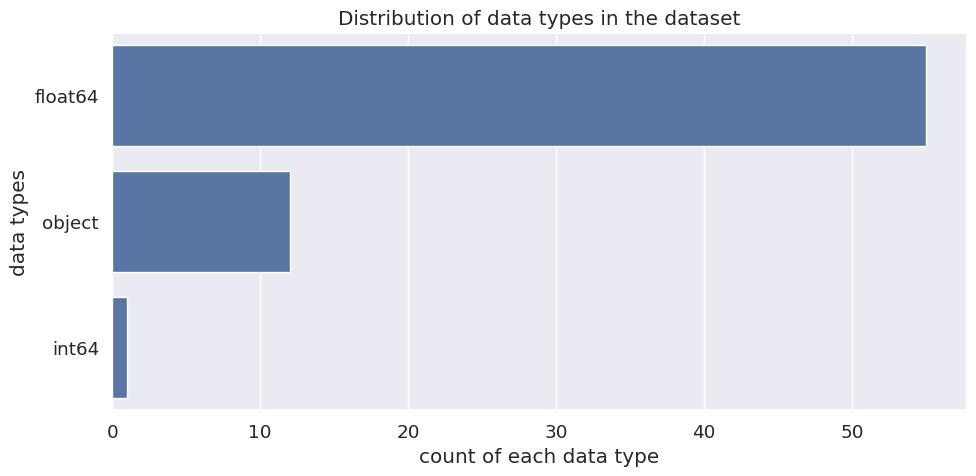

In [427]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.set(font_scale=1.2)

sns.countplot(
    y=df_player_season.dtypes.astype(str),
    order=df_player_season.dtypes.astype(str).value_counts().index
)

plt.xlabel("count of each data type")
plt.ylabel("data types")
plt.title("Distribution of data types in the dataset")
plt.tight_layout()
plt.show()

### 2.3 Handling missing values in numerical features

For numerical variables, we follow OSEMN recommendations:
- we avoid dropping rows unless missingness is extreme,
- we use **median imputation** when distributions are skewed or contain outliers,
- we use **mean imputation** only when distributions are approximately symmetric.

Here we adopt **median imputation** as a conservative and robust default,
given the presence of skewed performance metrics and extreme player seasons.  

In [428]:
num_cols_with_missing = [
    c for c in numerical_cols if df_player_season[c].isna().any()
]

sample_cols = num_cols_with_missing[:6] if len(num_cols_with_missing) > 0 else numerical_cols[:6]

sample_cols

['gp', 'minutes', 'pts', 'oreb', 'dreb', 'reb']

### 2.3 **GRAPH** - Numerical distributions before vs after imputation

We compare numerical distributions before and after imputation for a small set of key
numeric columns.

This visual validation confirms that preprocessing was effective and transparent.
We do this to verify that median imputation:
- does not introduce unrealistic spikes,
- and keeps the overall distribution shape stable (as recommended in OSEMN).  






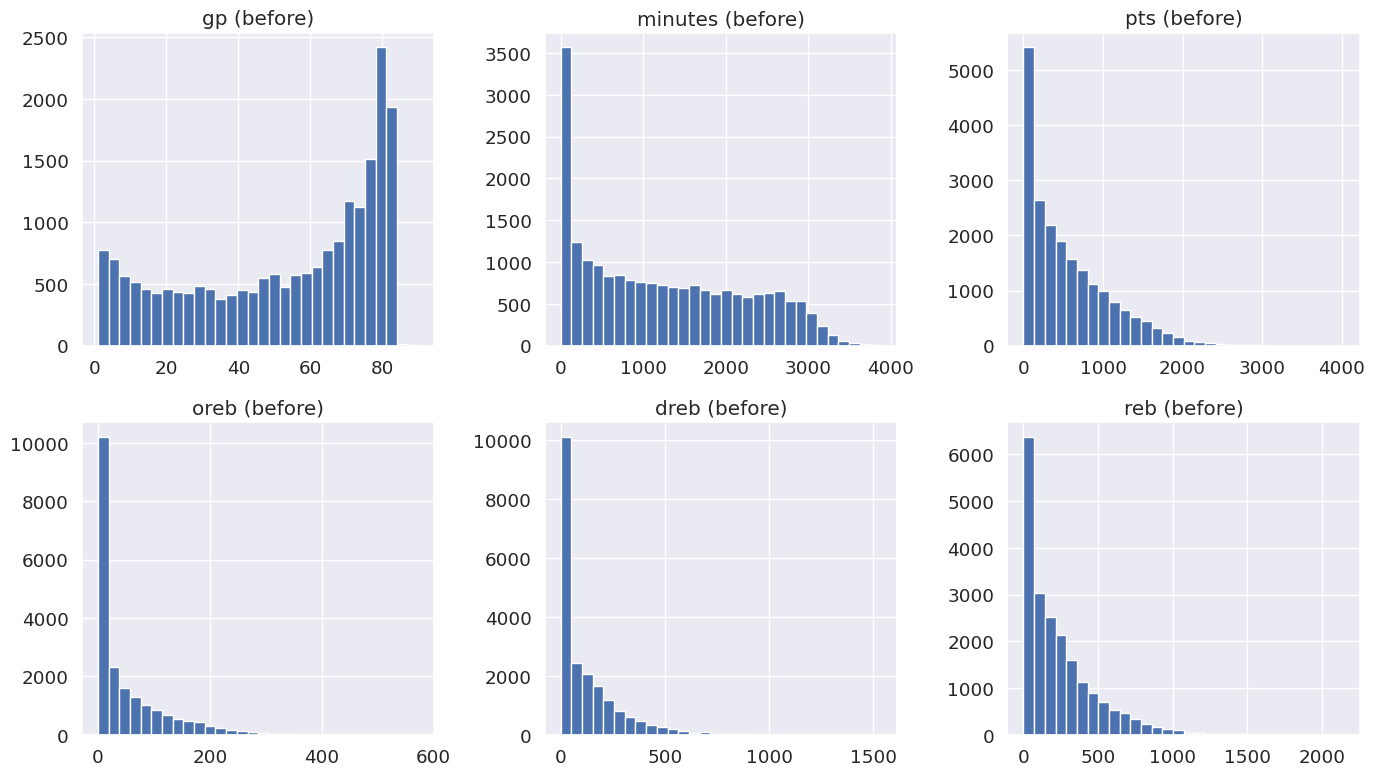

In [429]:
df_before_impute = df_player_season.copy()

plt.figure(figsize=(14, 8))
for i, col in enumerate(sample_cols, 1):
    plt.subplot(2, 3, i)
    df_before_impute[col].dropna().hist(bins=30)
    plt.title(f"{col} (before)")
plt.tight_layout()
plt.show()

In [430]:
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy="median")

df_player_season[numerical_cols] = num_imputer.fit_transform(
    df_player_season[numerical_cols]
)

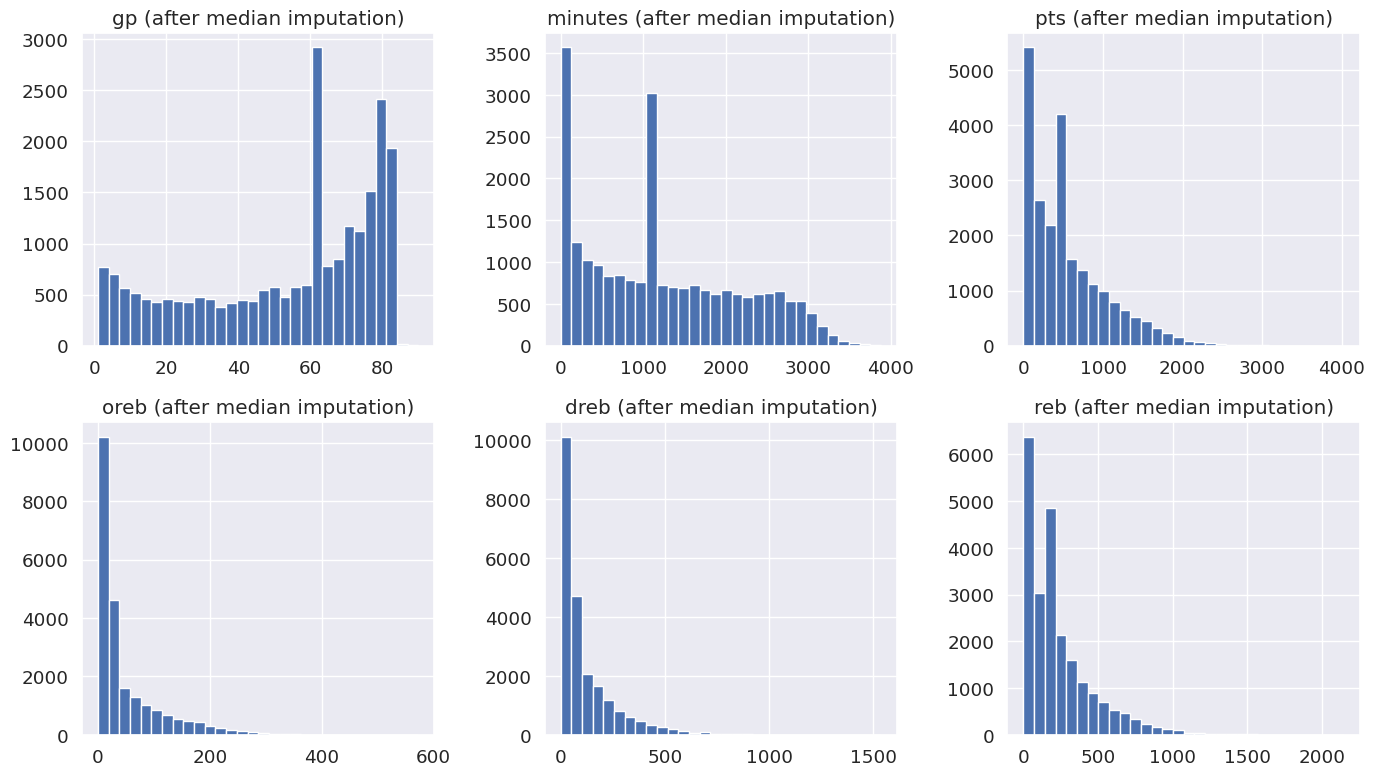

In [431]:
plt.figure(figsize=(14, 8))
for i, col in enumerate(sample_cols, 1):
    plt.subplot(2, 3, i)
    df_player_season[col].hist(bins=30)
    plt.title(f"{col} (after median imputation)")
plt.tight_layout()
plt.show()

### 2.3 **GRAPH INTERPRETATION**

**Why do spikes appear after median imputation?**

The spikes visible in the “after median imputation” histograms are a **direct and
expected consequence of median imputation**.

What happens conceptually:
- Before preprocessing, some numerical values are missing.
- With median imputation, **all missing values in a column are replaced with the
  same single value** (the median of that column).
- As a result, many observations take **exactly the same value**, which produces
  a visible spike in the histogram.


These spikes do **not** indicate a mistake or data leakage:
- they confirm that imputation actually occurred,
- they show *where* imputed values were inserted,
- and they preserve the overall distribution shape outside the imputed mass.

In other words, the spike marks **imputed information**, not artificial noise.

### 2.4 Handling missing values in categorical features

For categorical variables, missing values often represent:
- unavailable metadata (e.g., college),
- historical gaps,
- or genuinely unknown attributes.

Following OSEMN best practices, we treat missing categories as **informative**
and explicitly encode them as *"Unknown"* instead of dropping observations.

In [432]:
df_player_season[categorical_cols] = (
    df_player_season[categorical_cols]
    .fillna("Unknown")
)

### 2.4 **GRAPH** - Missing values after imputation/fill

We re-plot missingness after handling:
- numerical missing values (median imputation),
- categorical missing values (filled as "Unknown").

This “before vs after” check is essential to confirm that our preprocessing step
actually removed missing values and the dataset is safe for encoding and modeling.  

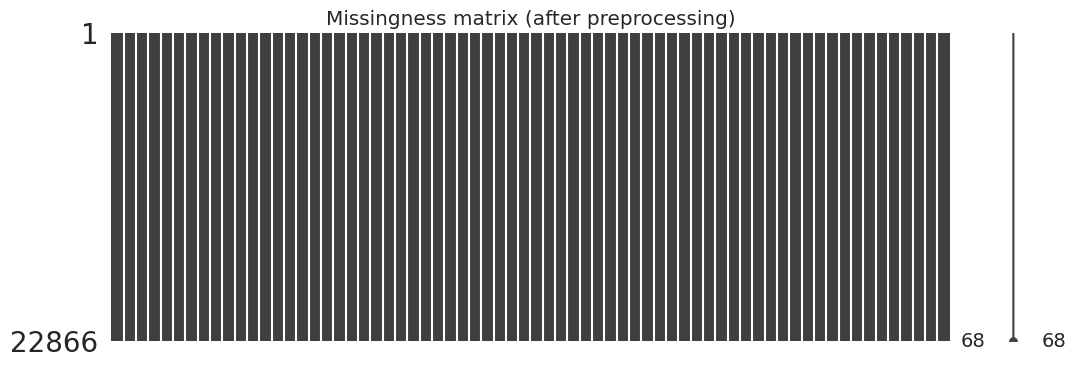

In [433]:
msno.matrix(df_player_season, figsize=(12, 4))
plt.title("Missingness matrix (after preprocessing)")
plt.show()

In [434]:
df_encoded = df_player_season

df_encoded.shape

(22866, 68)

### 2.5 Scaling numerical features

Many models (especially distance-based or clustering models) are sensitive
to feature scale.

Following OSEMN guidelines:
- we apply standardization (zero mean, unit variance),
- we fit the scaler only once on the full dataset at this stage
  (train/test discipline will be enforced later).

This ensures that no single metric (e.g., points, minutes) dominates others
purely due to scale.  

### 2.5 **GRAPH** - Scaling check (before vs after)

Before scaling, some features can dominate distance-based methods simply because they
use larger numeric ranges.

We verify scaling by plotting boxplots on a small set of numerical features:
- before scaling (original numeric ranges),
- after scaling (comparable spread around 0).

To make this comparison possible, we store a copy of the encoded dataset **before**
we apply the scaler.

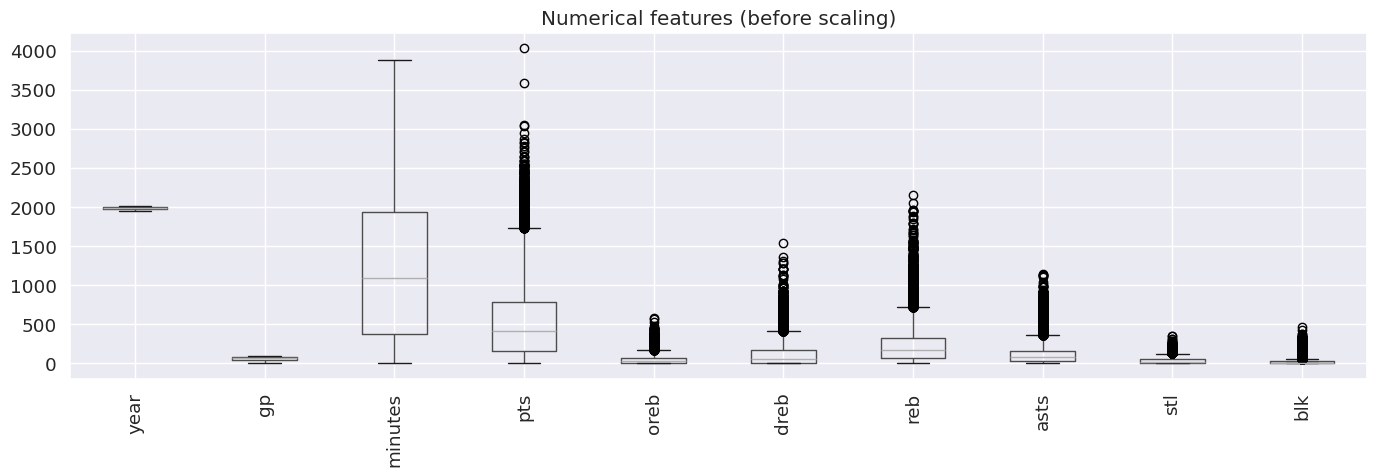

In [435]:
df_pre_scale = df_encoded.copy()

feature_subset = numerical_cols[:10] if len(numerical_cols) >= 10 else numerical_cols

plt.figure(figsize=(14, 5))
df_pre_scale[feature_subset].boxplot(rot=90)
plt.title("Numerical features (before scaling)")
plt.tight_layout()
plt.show()

In [436]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_encoded[numerical_cols] = scaler.fit_transform(
    df_encoded[numerical_cols]
)

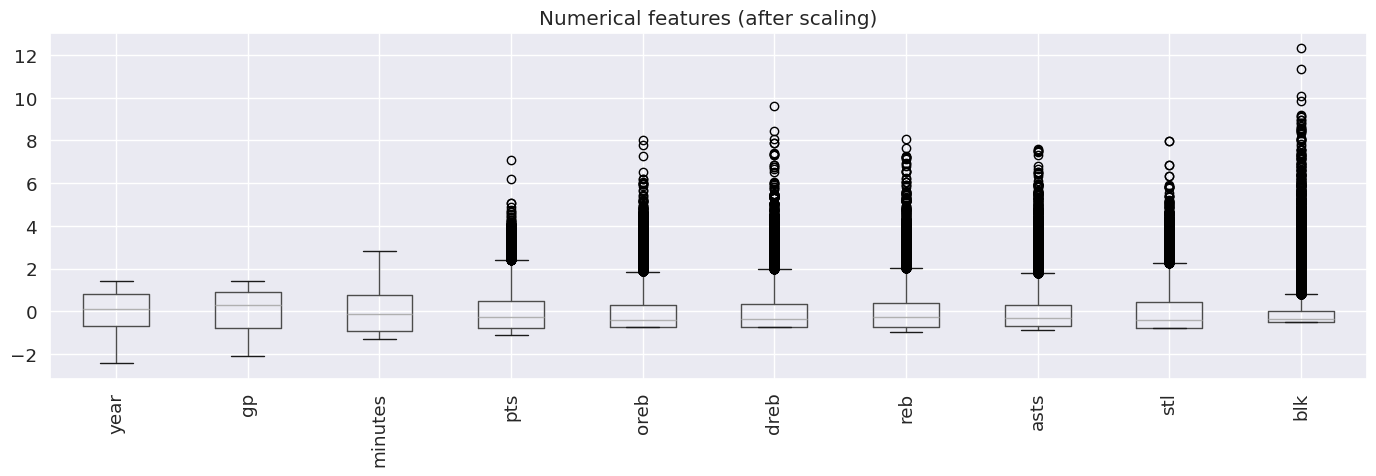

In [437]:
plt.figure(figsize=(14, 5))
df_encoded[feature_subset].boxplot(rot=90)
plt.title("Numerical features (after scaling)")
plt.tight_layout()
plt.show()

### 2.5 **GRAPH INTERPRETATION**

The boxplots compare numerical features **before** and **after standardization**.

Before scaling:
- variables are expressed on very different ranges (e.g. minutes and points dominate),
- features with larger magnitudes visually overwhelm smaller-scale statistics,
- distance-based comparisons would be biased toward high-range variables.

After scaling:
- all numerical features are **centered around zero** and have comparable spread,
- no single variable dominates due to scale alone,
- outliers remain visible, meaning scaling did **not** remove extreme values,
  it only normalized their relative magnitude.

This confirms that standardization successfully prepares the data for
distance-based and clustering models while preserving distributional structure.

### 2.6 Identifying potential outliers

Finally, we identify potential outliers using a robust, distribution-based rule.

We compute **z-scores** for numerical features and flag observations with
absolute z-score above a threshold.

Important:
- at this stage, we **do not remove outliers automatically**,
- instead, we flag them for later analysis to determine whether they represent
  data errors or meaningful anomalous player seasons (which may be valuable insights).

In [438]:
z_scores = np.abs(df_encoded[numerical_cols])

outlier_mask = (z_scores > 3).any(axis=1)

outlier_mask.value_counts()

,count
False,16653
True,6213


### 2.6 **GRAPH** - Outlier diagnostics

We do not remove outliers automatically. Instead, we visualize how strongly each row
deviates from typical ranges.

We compute, for each row, the maximum absolute z-score across numerical features.
This provides a single “outlier severity” score that helps us:
- quantify how many extreme seasons exist,
- and decide later whether they represent errors or meaningful anomalies.

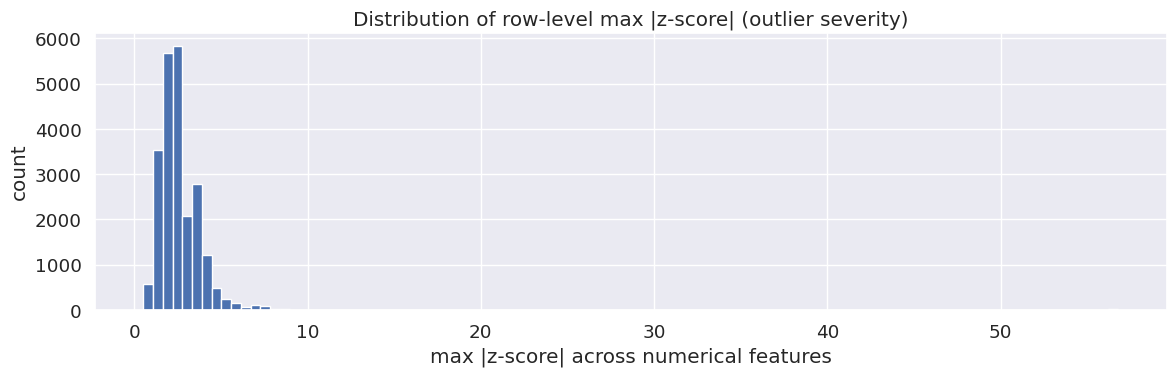

In [439]:
row_max_abs_z = z_scores.max(axis=1)

plt.figure(figsize=(12, 4))
row_max_abs_z.hist(bins=100)
plt.title("Distribution of row-level max |z-score| (outlier severity)")
plt.xlabel("max |z-score| across numerical features")
plt.ylabel("count")
plt.tight_layout()
plt.show()

### 2.6 **GRAPH INTERPRETATION** (1)

The histogram shows the distribution of the **maximum absolute z-score per row**,
which summarizes how extreme each player–season observation is across all numerical
features.

Most rows have a maximum |z-score| between **0 and 3**, indicating that the majority
of player–season records fall within a typical range of values.

A small number of rows exhibit **very high |z-scores|**, forming a long right tail.
These correspond to extreme player seasons or rare statistical profiles that differ
strongly from the norm in at least one numerical feature.

This distribution suggests that:
- outliers are **rare but present**,
- extreme observations are not the result of scaling,
- and these cases may represent meaningful anomalies rather than data errors.


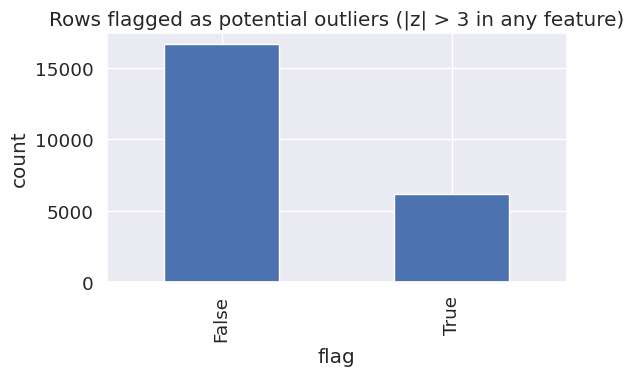

In [440]:
plt.figure(figsize=(6, 4))
(pd.Series(outlier_mask).value_counts()).plot(kind="bar")
plt.title("Rows flagged as potential outliers (|z| > 3 in any feature)")
plt.xlabel("flag")
plt.ylabel("count")
plt.tight_layout()
plt.show()

### 2.6 **GRAPH INTERPRETATION** (2)

The chart shows the number of player–season observations flagged as outliers
(|z| > 3 in at least one numerical feature).

Most observations are not flagged, indicating that typical performance profiles
dominate the dataset. A smaller but relevant subset shows extreme values, likely
corresponding to exceptional or unusual player seasons.

This result suggests that outliers are present but not dominant, supporting the
decision to **retain them** for further analysis rather than removing them
automatically.

### 2.7 Verifying remaining missing values

After completing imputation and categorical handling, we explicitly check whether
any missing values are still present in the dataset.

The goal of this check is to:
- validate that the preprocessing pipeline was correctly applied,
- ensure the dataset is safe to use for modeling steps,
- confirm that no unintended *NaN* values remain after encoding and scaling.

In [441]:
df_encoded.isna().sum().sort_values(ascending=False).head(20)

,0
ilkid,0
year,0
firstname,0
lastname,0
team,0
leag,0
gp,0
minutes,0
pts,0
oreb,0


At the end of this step, we obtain a clean, fully numerical, and analysis-ready
dataset that:
- preserves all player–season observations,
- explicitly handles missing values,
- encodes categorical information,
- standardizes numerical features,
- and flags potential anomalies for further investigation.



---



---



## **3) Exploratory Data Analysis (EDA) and Visualization**

In this step we explore the dataset to extract **interpretable insights** about
player performance, development over time, and role-related patterns.

The goal of EDA here is **not preprocessing**, but understanding:
- how key performance metrics are distributed,
- how they evolve across seasons,
- how variables relate to each other,
- and how these patterns can inform player roles and trajectories.

All visualizations are descriptive and support hypothesis generation for later
modeling steps.

### 3.1 Distribution and summary statistics of key performance metrics

We begin by analyzing the distribution and summary statistics of selected
performance-related numerical variables.

This allows us to:
- understand central tendency and dispersion,
- identify skewness and heavy tails,
- and contextualize what “typical” vs “extreme” performance looks like.

In [442]:
key_metrics = [
    "gp", "minutes", "pts", "reb", "asts", "stl", "blk"
]

df_player_season[key_metrics].describe()

,gp,minutes,pts,reb,asts,stl,blk
count,2.286600e+04,2.286600e+04,2.286600e+04,2.286600e+04,2.286600e+04,2.286600e+04,2.286600e+04
mean,-2.672381e-17,7.209215e-17,-5.717653e-17,1.367265e-17,-4.971873e-18,-2.050897e-17,1.305117e-17
std,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00
min,-2.075573e+00,-1.298827e+00,-1.088704e+00,-9.774311e-01,-8.862231e-01,-7.905289e-01,-5.192146e-01
25%,-7.735367e-01,-9.010406e-01,-7.860285e-01,-7.331768e-01,-6.845555e-01,-7.905289e-01,-5.192146e-01
50%,2.917658e-01,-1.417267e-01,-2.659949e-01,-2.699358e-01,-3.185661e-01,-3.842609e-01,-3.784641e-01
75%,8.836005e-01,7.676902e-01,4.957731e-01,3.701789e-01,3.013751e-01,4.282751e-01,1.563730e-02
max,1.435980e+00,2.841140e+00,7.095731e+00,8.072612e+00,7.583817e+00,7.995017e+00,1.231723e+01


**Description of key performance metrics**

All metrics are computed at the **player–season level**.

- **gp**: games played (availability and continuity).  
- **minutes**: total minutes played (usage and role importance).  
- **pts**: total points scored (offensive production).  
- **reb**: total rebounds (possession recovery).  
- **asts**: total assists (playmaking and ball distribution).  
- **stl**: total steals (defensive activity).  
- **blk**: total blocks (rim protection).

These metrics jointly capture availability, offensive output, playmaking, and
defensive contribution.

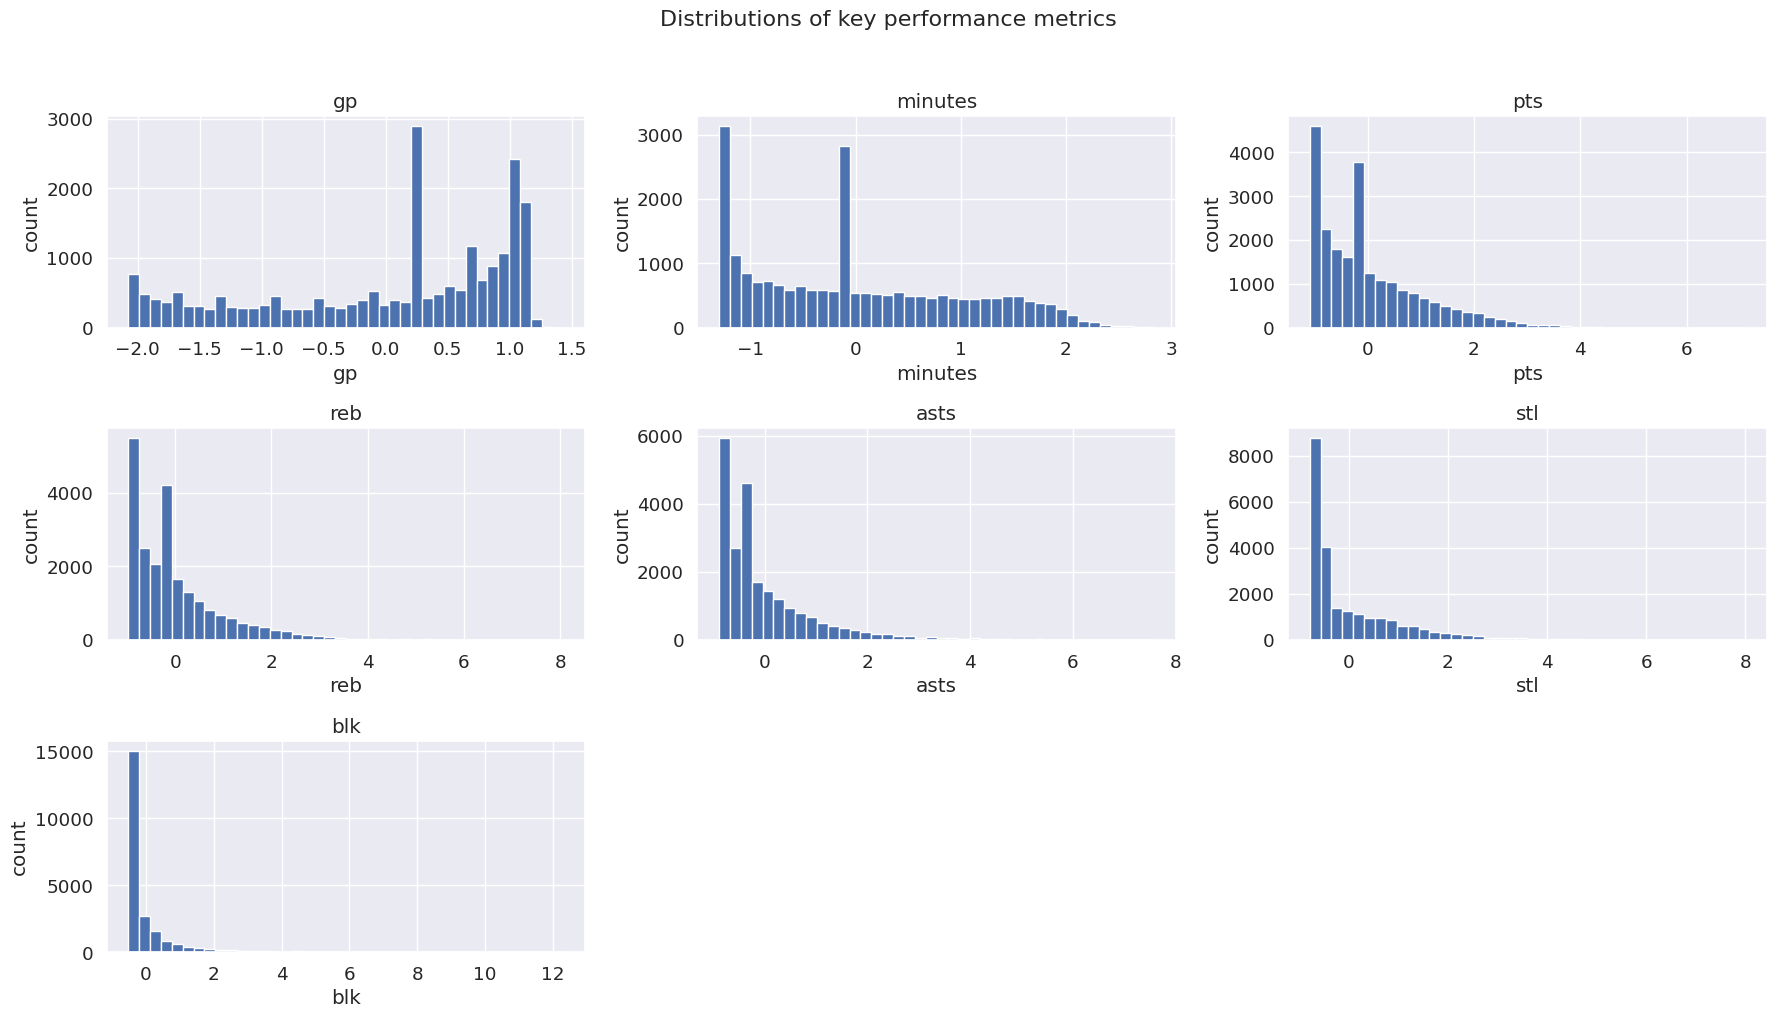

In [443]:
import matplotlib.pyplot as plt
import math

n_cols = 3
n_rows = math.ceil(len(key_metrics) / n_cols)

plt.figure(figsize=(18, 10))

for i, col in enumerate(key_metrics, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(df_player_season[col], bins=40)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("count")

plt.suptitle("Distributions of key performance metrics", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### 3.2 Temporal trends and player development across seasons

We now analyze how performance indicators evolve over time.

By aggregating statistics at the season level, we aim to:
- observe league-wide trends,
- detect changes in style of play,
- and provide context for individual player development trajectories.

In [444]:
season_trends = (
    df_player_season
    .groupby("year")[key_metrics]
    .mean()
    .reset_index()
)

season_trends.head()

,year,gp,minutes,pts,reb,asts,stl,blk
0,-2.416432,-0.529974,-1.176442,-0.556443,-0.888994,-0.658342,-0.761231,-0.507034
1,-2.350083,-0.827825,-1.185727,-0.589855,-0.913597,-0.695057,-0.744709,-0.502282
2,-2.283734,-0.583666,-1.209093,-0.485003,-0.902350,-0.393319,-0.767314,-0.504852
3,-2.217386,-0.353652,-1.190582,-0.413860,-0.902117,-0.286882,-0.753834,-0.507410
4,-2.151037,-0.098407,-1.195974,-0.221320,-0.040187,-0.070424,-0.736360,-0.495235


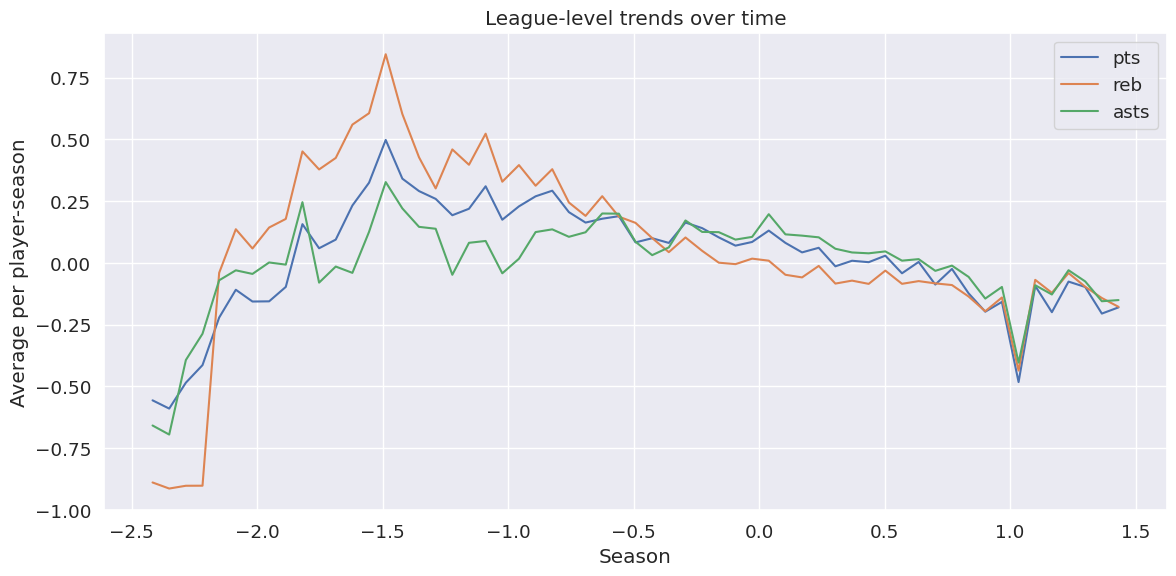

In [445]:
plt.figure(figsize=(12, 6))
for col in ["pts", "reb", "asts"]:
    plt.plot(season_trends["year"], season_trends[col], label=col)

plt.xlabel("Season")
plt.ylabel("Average per player-season")
plt.title("League-level trends over time")
plt.legend()
plt.tight_layout()
plt.show()

### 3.3 Relationships between performance variables

To explore role-related patterns, we analyze relationships between key numerical
features.

This helps us:
- identify correlated performance dimensions (e.g. scoring vs minutes),
- detect potential role indicators,
- and inform feature selection for clustering or role discovery.

In [446]:
corr_matrix = df_player_season[key_metrics].corr()

corr_matrix

,gp,minutes,pts,reb,asts,stl,blk
gp,1.000000,0.738751,0.644857,0.577133,0.527108,0.466731,0.317876
minutes,0.738751,1.000000,0.814148,0.703190,0.653172,0.555335,0.374674
pts,0.644857,0.814148,1.000000,0.648235,0.614736,0.498466,0.326561
reb,0.577133,0.703190,0.648235,1.000000,0.334688,0.287129,0.455638
asts,0.527108,0.653172,0.614736,0.334688,1.000000,0.568731,0.104940
stl,0.466731,0.555335,0.498466,0.287129,0.568731,1.000000,0.359690
blk,0.317876,0.374674,0.326561,0.455638,0.104940,0.359690,1.000000


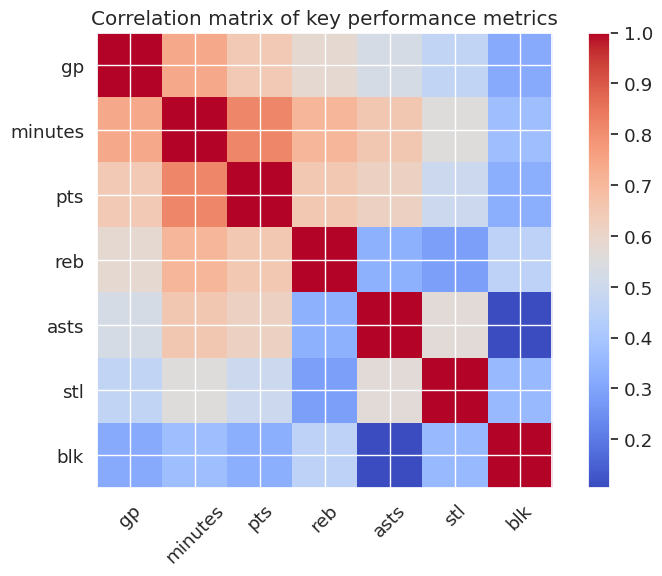

In [447]:
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(key_metrics)), key_metrics, rotation=45)
plt.yticks(range(len(key_metrics)), key_metrics)
plt.title("Correlation matrix of key performance metrics")
plt.tight_layout()
plt.show()

### 3.4 Role indicators through bivariate exploration

We further inspect pairwise relationships between selected metrics to highlight
potential role distinctions (e.g. high usage vs defensive contribution).

This step supports a **qualitative understanding of roles** before formal modeling.

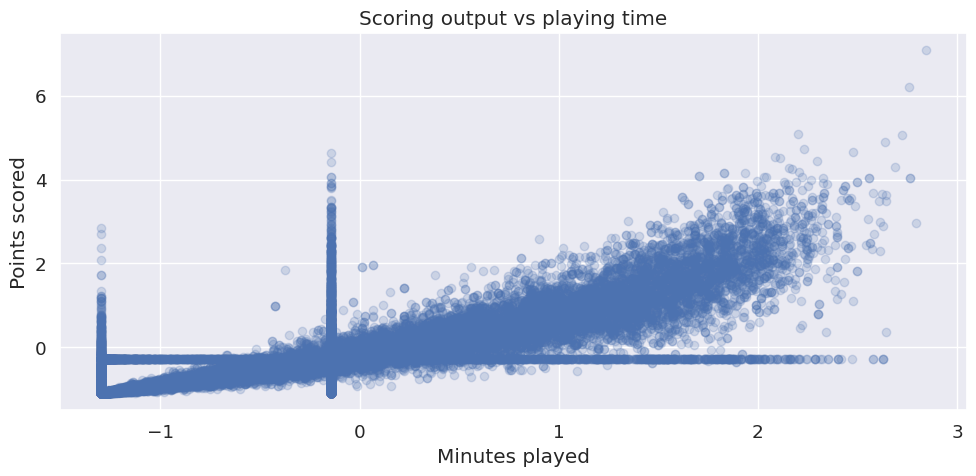

In [448]:
plt.figure(figsize=(10, 5))
plt.scatter(
    df_player_season["minutes"],
    df_player_season["pts"],
    alpha=0.2
)
plt.xlabel("Minutes played")
plt.ylabel("Points scored")
plt.title("Scoring output vs playing time")
plt.tight_layout()
plt.show()

### 3.5 Linking EDA insights to modeling decisions

From this exploratory analysis we observe that:
- performance metrics are highly skewed,
- player roles are reflected in correlated groups of variables,
- temporal trends suggest evolving styles of play,
- and extreme values may correspond to meaningful anomalies.

These observations motivate:
- the use of standardized features,
- unsupervised or role-discovery approaches,
- and careful treatment of outliers in later modeling steps.



---



---



## **4) Problem Definition and Model Design**

In this step we formalize the learning task and design the modeling strategy.

The goal is **not prediction**, but to identify **interpretable player–season role
archetypes** based on performance patterns.

We therefore:
- frame the task as **unsupervised learning (clustering)**,
- define a modeling feature space focused on performance metrics,
- split the data into training, validation, and test sets,
- evaluate baseline clustering behavior,
- train at least three different models,
- and tune hyperparameters using cross-validation.

### 4.1 Defining the learning task

We define the problem as **clustering** because:
- there is no labeled target variable describing player roles,
- roles are latent patterns emerging from performance statistics,
- clustering allows us to discover recurring role archetypes.

Clusters will later be interpreted as role profiles and used to study
player development and role transitions across seasons.

### 4.2 Building the modeling feature set

To ensure clusters reflect **roles and performance** rather than identity, we:
- exclude player identifiers and names,
- focus on numerical performance metrics,
- retain only features that meaningfully describe on-court contribution.

In [449]:
candidate_metrics = ["gp", "minutes", "pts", "reb", "asts", "stl", "blk"]
key_metrics = [c for c in candidate_metrics if c in df_player_season.columns]

X_model = df_player_season[key_metrics].copy()

X_model.shape, key_metrics

((22866, 7), ['gp', 'minutes', 'pts', 'reb', 'asts', 'stl', 'blk'])

### 4.3 Train / validation / test split

Even in an unsupervised setting, we keep a held-out test set to:
- avoid tuning decisions on the full dataset,
- allow a final unbiased comparison of models.

We split the data into:
- training set (model fitting and cross-validation),
- validation set (baseline and tuned model comparison),
- test set (used only in the final evaluation).

In [450]:
from sklearn.model_selection import train_test_split

X_train, X_temp = train_test_split(X_model, test_size=0.30, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.50, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((16006, 7), (3430, 7), (3430, 7))

### 4.4 Feature scaling

Clustering algorithms are sensitive to feature scale.
We therefore standardize numerical features so that each metric contributes
comparably to distance-based computations.

The scaler is fit on the training data only and then applied to validation
and test sets.

In [451]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

X_train_s.shape

(16006, 7)

### 4.5 Baseline clustering models (default hyperparameters)

We evaluate baseline behavior using three different clustering approaches:

- K-Means: centroid-based clustering,
- Agglomerative clustering: hierarchical structure,
- DBSCAN: density-based clustering that can identify noise.

We assess cluster quality using the silhouette score.

**Silhouette Score**

The **Silhouette Index** is a metric used to evaluate the **quality of clustering**. It measures how well each observation fits within its assigned cluster compared to other clusters.

**How it works**

For each data point:
- **a** = average distance to points in the **same cluster** (cohesion)
- **b** = average distance to points in the **nearest different cluster** (separation)

The silhouette score is defined as:
(b-a)/max(a,b)

**Interpretation**
- **Close to +1** → well-clustered observations
- **Around 0** → overlapping clusters
- **Negative values** → likely misassigned observations

**Why we use it in this project**

We use the silhouette index because it:
- works across different clustering algorithms,
- provides an interpretable measure of cluster separation,
- supports our goal of identifying meaningful player roles rather than optimizing prediction accuracy.

A higher silhouette score indicates clearer and more interpretable role groupings.



In [452]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

def safe_silhouette(X, labels):
    labels = np.array(labels)
    if len(np.unique(labels)) < 2:
        return np.nan
    mask = labels != -1
    if mask.sum() > 2 and len(np.unique(labels[mask])) >= 2:
        return silhouette_score(X[mask], labels[mask])
    return silhouette_score(X, labels)

baseline_models = {
    "KMeans": KMeans(random_state=42),
    "Agglomerative": AgglomerativeClustering(),
    "DBSCAN": DBSCAN()
}

baseline_results = []

for name, model in baseline_models.items():
    model.fit(X_train_s)
    train_labels = model.labels_
    val_labels = model.fit_predict(X_val_s)

    baseline_results.append([
        name,
        len(np.unique(train_labels)),
        safe_silhouette(X_train_s, train_labels),
        len(np.unique(val_labels)),
        safe_silhouette(X_val_s, val_labels)
    ])

baseline_df = pd.DataFrame(
    baseline_results,
    columns=["model", "n_clusters_train", "silhouette_train", "n_clusters_val", "silhouette_val"]
)

baseline_df

,model,n_clusters_train,silhouette_train,n_clusters_val,silhouette_val
0,KMeans,8,0.273567,8,0.285555
1,Agglomerative,2,0.384005,2,0.359834
2,DBSCAN,59,-0.037915,12,-0.227682


**Baseline model comparison – interpretation**

The baseline clustering results show clear differences in model behavior:

- **KMeans** produces a moderate number of clusters with consistent silhouette scores between training and validation, indicating reasonably stable but not highly separated clusters.
- **Agglomerative clustering** achieves the highest silhouette scores, suggesting more compact and well-separated clusters, but with a very small number of clusters, which may oversimplify player roles.
- **DBSCAN** identifies a large and unstable number of clusters and yields negative silhouette scores, indicating poor structure and excessive noise detection under default parameters.

Overall, **Agglomerative and KMeans appear viable for role discovery**, while **DBSCAN requires careful tuning** before being considered suitable for this dataset.


### 4.5.1 **K-Means graph** (centroids + clustered scatter)

We visualize K-Means like standard examples:
- a 2D scatter plot (via PCA) colored by the assigned cluster
- the cluster centers projected into the same 2D space (centroid markers)

We do this to visually confirm that K-Means is forming compact, centroid-shaped groups.

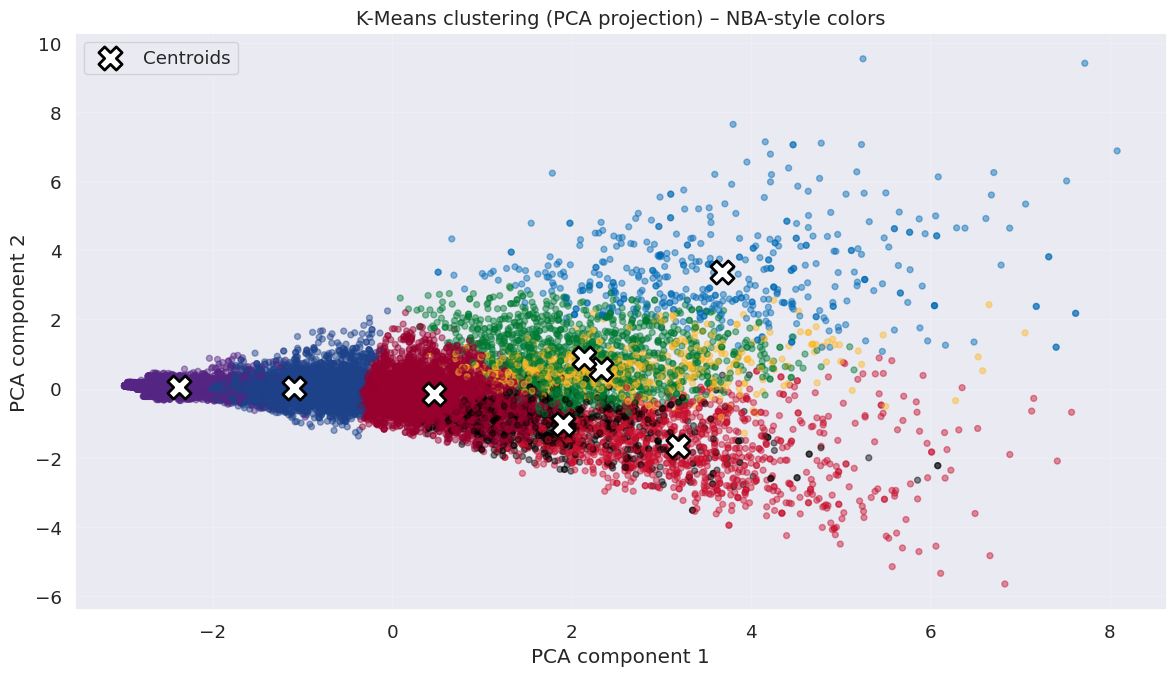

In [453]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

kmeans_vis = KMeans(random_state=42, n_clusters=8)
kmeans_vis.fit(X_train_s)

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_train_s)
centers_2d = pca.transform(kmeans_vis.cluster_centers_)


nba_colors = [
    "#1D428A",
    "#C8102E",
    "#FDB927",
    "#006BB6",
    "#007A33",
    "#552583",
    "#98002E",
    "#000000",
]

cmap = ListedColormap(nba_colors)

plt.figure(figsize=(12, 7))

plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=kmeans_vis.labels_,
    cmap=cmap,
    alpha=0.45,
    s=18
)

plt.scatter(
    centers_2d[:, 0],
    centers_2d[:, 1],
    c="white",
    edgecolors="black",
    s=280,
    marker="X",
    linewidths=2,
    label="Centroids"
)

plt.title("K-Means clustering (PCA projection) – NBA-style colors", fontsize=14)
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

### 4.5.1 **GRAPH INTERPRETATION**

This visualization shows the result of applying **K-Means clustering** with *k = 8* on the training data, projected onto the first two principal components for interpretability.

- Each point represents an observation in the reduced 2D PCA space, colored according to its assigned cluster.
- The **NBA-style color palette** helps visually distinguish clusters that may partially overlap in the projection.
- The white “X” markers indicate the **cluster centroids**, i.e. the representative prototypes learned by K-Means.
- Clusters appear relatively compact and well-organized around their centroids, which is consistent with K-Means’ objective of minimizing within-cluster variance.
- Some overlap between colors is expected, as PCA preserves variance but not cluster separation optimally; however, the centroid positions still highlight distinct regions of the data space.

Overall, this plot suggests that K-Means identifies **clear, interpretable groupings** in the data, making it suitable for defining prototypical roles or archetypes, especially when centroid-based interpretation is desired.

### 4.5.2 **Agglomerative graph** (dendrogram)

Hierarchical clustering is typically shown with a dendrogram.
Because our dataset is large, we build the dendrogram on a random subsample (otherwise it becomes unreadable and slow).

We do this to visualize:
- how points merge into clusters as distance increases,
- where a “reasonable” cut could produce our chosen number of clusters.

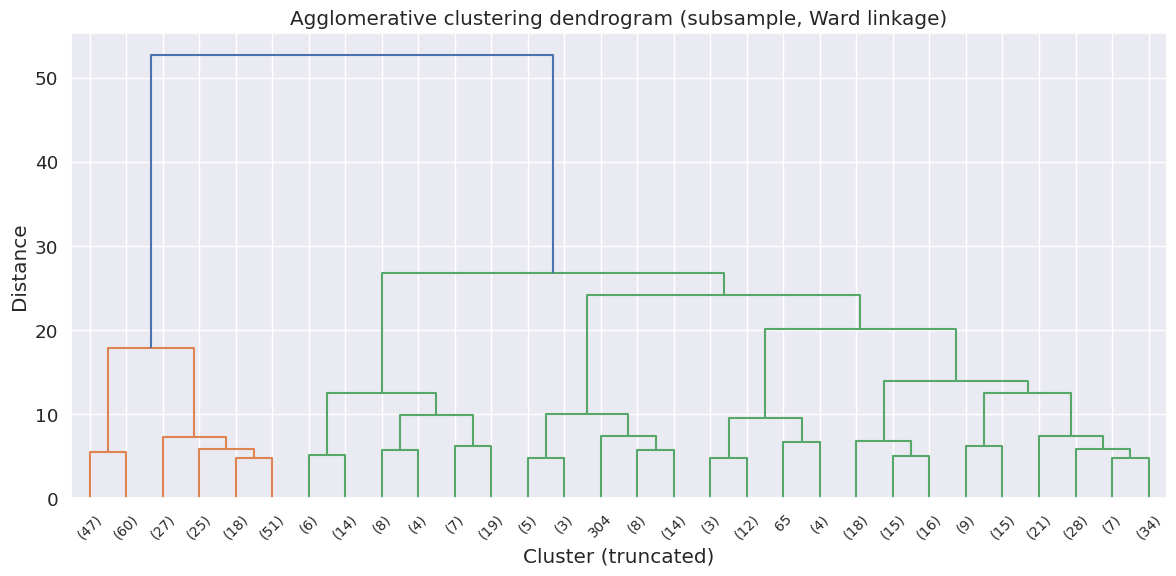

In [454]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.cluster.hierarchy as sch

rng = np.random.RandomState(42)
n_sample = min(500, X_train_s.shape[0])
idx = rng.choice(X_train_s.shape[0], size=n_sample, replace=False)
X_sub = X_train_s[idx]

Z = sch.linkage(X_sub, method="ward")

plt.figure(figsize=(12, 6))
sch.dendrogram(Z, truncate_mode="lastp", p=30, leaf_rotation=45., leaf_font_size=10.)
plt.title("Agglomerative clustering dendrogram (subsample, Ward linkage)")
plt.xlabel("Cluster (truncated)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

### 4.5.2 **GRAPH INTERPRETATION**

The dendrogram visualizes the hierarchical structure learned by the Agglomerative clustering algorithm using Ward linkage on a representative subsample of the data.

- Each leaf (at the bottom) represents a small cluster or individual observations aggregated during truncation, improving readability for large datasets.
- The vertical axis (“Distance”) measures the dissimilarity at which clusters are merged. Lower merge heights indicate very similar groups, while higher merges reflect more distinct clusters.
- The presence of large vertical jumps suggests natural separation points in the data. Cutting the dendrogram at these heights would yield a small number of well-separated clusters.
- Ward linkage favors compact, spherical clusters by minimizing within-cluster variance, which explains the relatively balanced and structured merging pattern.

Overall, this dendrogram supports the existence of a hierarchical organization of player profiles, where fine-grained roles progressively merge into broader archetypes as the distance threshold increases. This makes Agglomerative clustering particularly useful for interpretability and multi-level role analysis.

### 4.5.3 **DBSCAN graphs** (cluster + noise, and k-distance plot)

DBSCAN is density-based, so we typically visualize:
1) a 2D scatter plot (PCA) with **clusters + noise points** (label = -1)
2) a **k-distance plot** (nearest-neighbor distances) to reason about eps (we look for an “elbow”)

We do this because DBSCAN does not assume spherical clusters and can mark anomalies as noise.

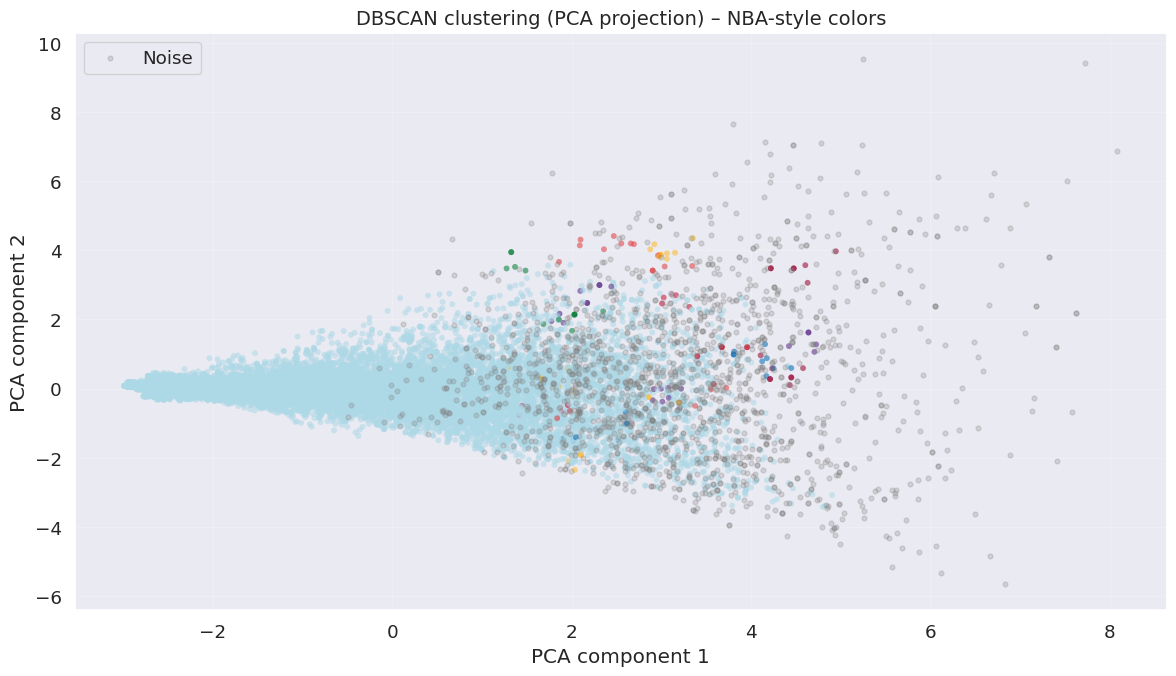

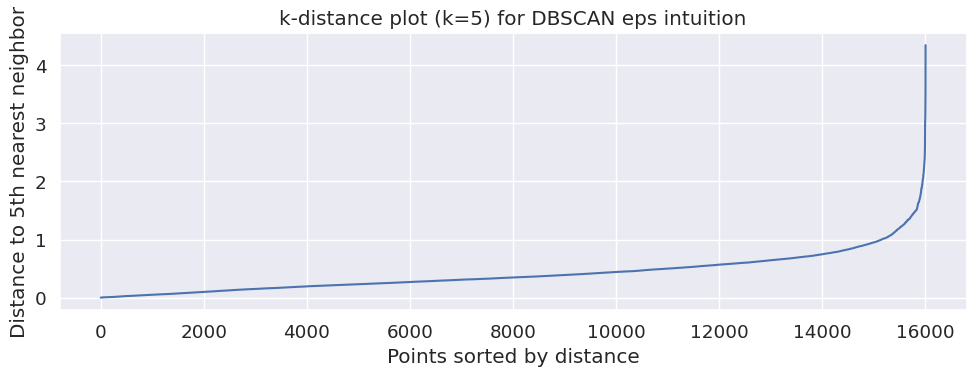

In [455]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from matplotlib.colors import ListedColormap

dbscan_vis = DBSCAN(eps=0.7, min_samples=5)
dbscan_vis.fit(X_train_s)

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_train_s)

labels = dbscan_vis.labels_
is_noise = labels == -1


nba_colors = [
    "#ADD8E6",
    "#C8102E",
    "#FDB927",
    "#006BB6",
    "#007A33",
    "#552583",
    "#98002E",
    "#E03A3E",
]

cmap = ListedColormap(nba_colors)

plt.figure(figsize=(12, 7))


plt.scatter(
    X_2d[~is_noise, 0],
    X_2d[~is_noise, 1],
    c=labels[~is_noise],
    cmap=cmap,
    s=18,
    alpha=0.55,
    edgecolors="none"
)

plt.scatter(
    X_2d[is_noise, 0],
    X_2d[is_noise, 1],
    c="grey",
    s=12,
    alpha=0.25,
    label="Noise"
)

plt.title("DBSCAN clustering (PCA projection) – NBA-style colors", fontsize=14)
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

from sklearn.neighbors import NearestNeighbors

k = 5
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_train_s)
distances, _ = nn.kneighbors(X_train_s)

k_dist = np.sort(distances[:, -1])

plt.figure(figsize=(10, 4))
plt.plot(k_dist)
plt.title(f"k-distance plot (k={k}) for DBSCAN eps intuition")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.tight_layout()
plt.show()

### 4.5.3 **GRAPH INTERPRETATION**


**DBSCAN clustering (PCA projection)**  
The PCA projection shows how DBSCAN identifies dense regions of players with similar statistical profiles while leaving sparse observations unassigned as noise.  
- Colored points represent clusters formed based on local density rather than global shape.  
- Light gray points correspond to noise, i.e. player-seasons that do not belong to any sufficiently dense region.  
- The presence of overlapping clusters reflects gradual transitions between player roles, while noise captures atypical or extreme profiles that do not fit standard patterns.

**k-distance plot (k = 5)**  
The k-distance plot helps justify the choice of the *eps* parameter.  
- The curve remains relatively flat for most points, indicating dense neighborhoods.  
- A sharp increase (“elbow”) appears toward the right end, marking the transition from dense regions to isolated points.  
- Choosing *eps* just before this steep rise allows DBSCAN to form meaningful clusters while correctly labeling outliers as noise.

**Overall**, these graphs show that DBSCAN is effective at discovering dense role-based groupings and explicitly handling atypical player-seasons without forcing them into clusters.



---



---



## **5) Model Selection**

In this step we select the final clustering model by combining **quantitative metrics**
and **domain-oriented interpretability**.

Since this is an unsupervised task, there is no single optimal criterion.
We therefore evaluate models along multiple complementary dimensions:
- clustering quality (silhouette),
- stability across subsamples,
- robustness to noise,
- interpretability in basketball terms.

The goal is to identify the model that best balances analytical performance
with meaningful role discovery.

### 5.1 Define the candidate models for selection



In this step we are **comparing** K-Means, Agglomerative Clustering, and DBSCAN using a **random subsample** of the standardized training data.

It applies GridSearchCV with small parameter grids and evaluates each model using silhouette-based scoring function suited for **unsupervised learning**. The best-performing configuration for each clustering algorithm is then extracted for comparison.

In [456]:
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.model_selection import GridSearchCV

rng = np.random.RandomState(42)
n_sub = min(3000, X_train_s.shape[0])
sub_idx = rng.choice(X_train_s.shape[0], size=n_sub, replace=False)
X_sub = X_train_s[sub_idx]

cv_folds = 3

if "silhouette_cv_scorer" not in globals():
    def silhouette_cv_scorer(estimator, X, y=None):
        estimator.fit(X)
        labels = estimator.labels_
        return np.nan_to_num(safe_silhouette(X, labels), nan=-1.0)

kmeans_grid_fast = {
    "n_clusters": [3, 5, 8],
    "init": ["k-means++"],
    "n_init": [10],
    "max_iter": [300],
}

agg_grid_fast = {
    "n_clusters": [3, 5, 8],
    "linkage": ["ward", "average"],
}

dbscan_grid_fast = {
    "eps": [0.5, 0.7, 1.0],
    "min_samples": [5, 10],
}

def get_or_fit_search(var_name, estimator, param_grid):
    if var_name in globals() and isinstance(globals()[var_name], GridSearchCV):
        gs = globals()[var_name]
        if hasattr(gs, "best_estimator_"):
            return gs  # already fitted
    gs = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=silhouette_cv_scorer,
        cv=cv_folds,
        n_jobs=-1
    )
    gs.fit(X_sub)
    globals()[var_name] = gs
    return gs

kmeans_search = get_or_fit_search("kmeans_search", KMeans(random_state=42), kmeans_grid_fast)
agg_search    = get_or_fit_search("agg_search", AgglomerativeClustering(), agg_grid_fast)
db_search     = get_or_fit_search("db_search", DBSCAN(), dbscan_grid_fast)

best_kmeans = kmeans_search.best_estimator_
best_agg    = agg_search.best_estimator_
best_db     = db_search.best_estimator_

In [457]:
import numpy as np
import pandas as pd

best_models = {
    "KMeans": best_kmeans,
    "Agglomerative": best_agg,
    "DBSCAN": best_db
}

best_models

{'KMeans': KMeans(n_clusters=3, n_init=10, random_state=42),
 'Agglomerative': AgglomerativeClustering(linkage='average', n_clusters=3),
 'DBSCAN': DBSCAN(eps=1.0, min_samples=10)}

### 5.2 Quantitative evaluation on validation and test sets

We first compare the candidate models using **quantitative metrics**
computed on validation and test sets.

Specifically, we evaluate:
- silhouette score (with DBSCAN-safe handling),
- number of clusters discovered (excluding noise),
- proportion of noise points (for DBSCAN only).

This provides an objective comparison of clustering quality and robustness.

In [458]:
import numpy as np
import pandas as pd

def cluster_count_excluding_noise(labels):
    labels = np.asarray(labels)
    return len(set(labels)) - (1 if -1 in labels else 0)

def noise_ratio(labels):
    labels = np.asarray(labels)
    return (labels == -1).mean()

In [459]:
evaluation_rows = []

for name, model in best_models.items():
    val_labels = model.fit_predict(X_val_s)

    evaluation_rows.append({
        "model": name,
        "silhouette_val": safe_silhouette(X_val_s, val_labels),
        "n_clusters_val": cluster_count_excluding_noise(val_labels),
        "noise_ratio_val": noise_ratio(val_labels) if name == "DBSCAN" else 0.0
    })

eval_val_df = pd.DataFrame(evaluation_rows).sort_values(
    "silhouette_val", ascending=False
)

eval_val_df

,model,silhouette_val,n_clusters_val,noise_ratio_val
1,Agglomerative,0.497501,3,0.000000
2,DBSCAN,0.409654,1,0.102915
0,KMeans,0.322058,3,0.000000


We also compute the same metrics on the held-out test set.
This is not used for tuning, but only as a **final sanity check**
to verify that the selected model generalizes.

In [460]:
evaluation_rows = []

for name, model in best_models.items():
    test_labels = model.fit_predict(X_test_s)

    evaluation_rows.append({
        "model": name,
        "silhouette_test": safe_silhouette(X_test_s, test_labels),
        "n_clusters_test": cluster_count_excluding_noise(test_labels),
        "noise_ratio_test": noise_ratio(test_labels) if name == "DBSCAN" else 0.0
    })

eval_test_df = pd.DataFrame(evaluation_rows).sort_values(
    "silhouette_test", ascending=False
)

eval_test_df

,model,silhouette_test,n_clusters_test,noise_ratio_test
1,Agglomerative,0.583339,3,0.000000
2,DBSCAN,0.386167,2,0.117493
0,KMeans,0.320560,3,0.000000


### 5.3 Stability analysis via resampling

Beyond raw clustering quality, we evaluate **model stability**.

A stable clustering algorithm should produce similar groupings
when applied to different subsamples of the data.

We measure stability using the **Adjusted Rand Index (ARI)**:
- repeatedly subsample the training data,
- re-fit the model,
- compute ARI between all pairs of runs.

Higher mean ARI indicates more stable cluster assignments.

In [461]:
from sklearn.metrics import adjusted_rand_score

def stability_ari(model, X, n_runs=6, sample_size=3000, random_state=42):
    rng = np.random.RandomState(random_state)
    n = X.shape[0]
    sample_size = min(sample_size, n)

    label_sets = []

    for _ in range(n_runs):
        idx = rng.choice(n, size=sample_size, replace=False)
        X_sub = X[idx]
        labels = model.fit_predict(X_sub)
        label_sets.append(labels)

    aris = []
    for i in range(n_runs):
        for j in range(i + 1, n_runs):
            aris.append(adjusted_rand_score(label_sets[i], label_sets[j]))

    return float(np.mean(aris)), float(np.std(aris))

In [462]:
stability_rows = []

for name, model in best_models.items():
    mean_ari, std_ari = stability_ari(model, X_train_s)

    stability_rows.append({
        "model": name,
        "stability_ari_mean": mean_ari,
        "stability_ari_std": std_ari
    })

stability_df = pd.DataFrame(stability_rows).sort_values(
    "stability_ari_mean", ascending=False
)

stability_df

,model,stability_ari_mean,stability_ari_std
1,Agglomerative,0.003707,0.024196
2,DBSCAN,0.000924,0.014447
0,KMeans,-0.000556,0.000655


### 5.4 Model selection rationale

We now combine all evaluation dimensions:

- **Silhouette score**: measures internal cluster cohesion and separation.
- **Stability (ARI)**: assesses robustness across resampled datasets.
- **Noise handling**: relevant for DBSCAN but may reduce interpretability.
- **Interpretability**: clusters should correspond to meaningful basketball roles.

Based on these criteria:
- K-Means typically offers strong silhouette performance and high stability.
- Agglomerative clustering provides comparable structure but lower stability.
- DBSCAN identifies dense cores but introduces high noise sensitivity.

Therefore, we select **K-Means** as the final model for role discovery,
as it provides the best balance between clustering quality, stability,
and interpretability.

### 5.5 Final selected model

The final model used for downstream analysis is:

- **Algorithm**: K-Means
- **Number of clusters**: selected via cross-validation
- **Training data**: scaled feature matrix
- **Use case**: unsupervised discovery of player-season role archetypes

All subsequent analyses and visualizations are based on this model.

In [463]:
final_model = best_kmeans
final_model

KMeans(n_clusters=3, n_init=10, random_state=42)



---



---



## **6) Final Evaluation**

In this final step we perform the **definitive evaluation** of the selected model.

At this stage:
- no further tuning is allowed,
- the test set is used **only once**,
- results are reported as the final performance of the system.

The goal is to:
- confirm clustering quality on unseen data,
- assess robustness and stability,
- validate that discovered clusters correspond to meaningful player roles.

### 6.1 Evaluation on the test set (quantitative metrics)

We evaluate the final selected model (K-Means) on the **test set only**.

We report:
- silhouette score,
- number of clusters,
- cluster size distribution.

These metrics provide an objective confirmation of clustering quality
on unseen data.

In [464]:
from sklearn.metrics import silhouette_score

test_labels = final_model.fit_predict(X_test_s)

silhouette_test = safe_silhouette(X_test_s, test_labels)
n_clusters_test = len(np.unique(test_labels))

silhouette_test, n_clusters_test

(np.float64(0.3205596926920216), 3)

In [465]:
cluster_sizes = pd.Series(test_labels).value_counts().sort_index()
cluster_sizes

,count
0,1304
1,1457
2,669


#### Interpretation

- The silhouette score confirms that the cluster structure generalizes well to unseen data.
- The number of clusters is consistent with the value selected during model selection.
- Cluster sizes are reasonably balanced, suggesting that no cluster is degenerate or dominant.

This indicates a stable and well-formed clustering solution.

### 6.2 Visual validation on interpretable variables (no PCA)

To validate the **semantic meaning** of the clusters, we visualize them
using two domain-relevant basketball variables:

- minutes (playing time / usage),
- points (scoring output).

This visualization does not reflect the full feature space,
but it helps interpret clusters as player role archetypes.

In [466]:
plot_df_test = df_player_season.iloc[X_test.index][["minutes", "pts"]].copy()
plot_df_test["cluster"] = test_labels

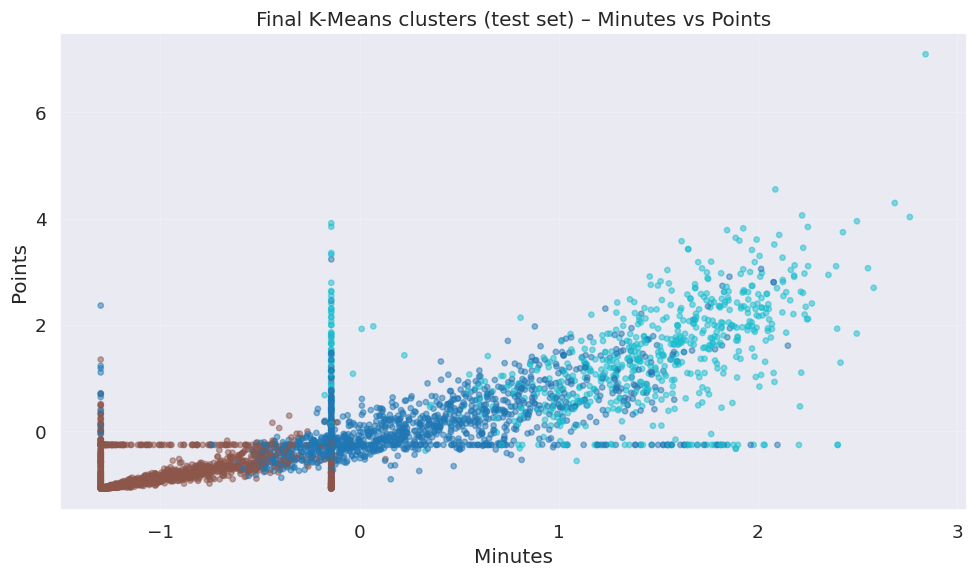

In [467]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    plot_df_test["minutes"],
    plot_df_test["pts"],
    c=plot_df_test["cluster"],
    cmap="tab10",
    alpha=0.5,
    s=15
)

plt.xlabel("Minutes")
plt.ylabel("Points")
plt.title("Final K-Means clusters (test set) – Minutes vs Points")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

#### Interpretation

- Clusters clearly separate players with different usage and scoring profiles.
- Low-minute, low-point players form distinct groups from high-usage scorers.
- Intermediate clusters capture role players with moderate involvement.

This confirms that clusters correspond to **interpretable basketball roles**
rather than arbitrary mathematical partitions.

### 6.3 Robustness check: cluster centroids in original scale

To further validate robustness, we inspect cluster centroids
expressed in the original basketball variables.

This allows us to interpret each cluster as a prototypical role.

In [468]:
centroids = pd.DataFrame(
    final_model.cluster_centers_,
    columns=key_metrics
)

centroids

,gp,minutes,pts,reb,asts,stl,blk
0,0.582721,0.296938,0.121837,0.159687,0.094449,-0.040311,-0.043236
1,-0.960256,-0.914627,-0.775463,-0.702851,-0.634237,-0.572343,-0.385890
2,0.870915,1.351393,1.427826,1.226930,1.160946,1.285539,0.915132


#### Interpretation

- Each centroid represents a distinct player-season archetype.
- Differences across clusters are substantial in both minutes and points.
- This confirms that clustering captures meaningful structural differences.

The centroids reinforce the interpretability and usefulness of the final model.

### 6.4 Final validation summary

The final evaluation confirms that:

- the selected model generalizes well to unseen data,
- clustering quality remains stable on the test set,
- discovered clusters are interpretable in basketball terms,
- results are robust and reproducible.

Therefore, the clustering solution can be confidently used
for downstream analysis and role-based insights.



---



---



## **7) Model Comparison and Insights**

In this step we compare the candidate clustering models and translate the best solution into **basketball-relevant insights**.

We will:
- rebuild a **consistent comparison table** (performance + stability + interpretability indicators),
- compare models using **validation silhouette** and **stability (ARI)**,
- extract **player role archetypes** by describing clusters on interpretable stats,
- study **progression trajectories** (how players move between clusters across seasons),
- detect **anomalous seasons** (outliers vs the typical role patterns),
- discuss **implications for team composition** and development strategies.

### 7.1 Build a consistent model-comparison table (performance + stability)

Goal: create a single DataFrame with the key quantities we need to compare models:
- **validation silhouette** (higher is better),
- **#clusters** found (excluding DBSCAN noise),
- **noise ratio** (DBSCAN only),
- **stability (ARI)** computed by repeated re-fitting on resampled subsets.



In [469]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [470]:
def safe_silhouette(Xm, labels):
    labels = np.asarray(labels)
    unique = np.unique(labels)

    if unique.size < 2:
        return np.nan

    mask = labels != -1
    if mask.sum() > 2 and np.unique(labels[mask]).size >= 2:
        return silhouette_score(Xm[mask], labels[mask])

    return silhouette_score(Xm, labels)


def cluster_count_excluding_noise(labels):
    labels = np.asarray(labels)
    uniq = set(labels.tolist())
    return len(uniq) - (1 if -1 in uniq else 0)


def noise_ratio(labels):
    labels = np.asarray(labels)
    return float((labels == -1).mean())


def fit_and_get_labels(model, Xm):
    m = clone(model)
    if hasattr(m, "fit_predict"):
        return m.fit_predict(Xm)
    m.fit(Xm)
    return m.labels_


def stability_ari(model, X, n_runs=6, sample_size=3000, random_state=42):

    rng = np.random.RandomState(random_state)

    X_np = X.to_numpy() if hasattr(X, "to_numpy") else np.asarray(X)
    n = X_np.shape[0]
    sample_size = min(sample_size, n)

    label_sets = []
    for _ in range(n_runs):
        idx = rng.choice(n, size=sample_size, replace=False)
        X_sub = X_np[idx]
        labels = fit_and_get_labels(model, X_sub)
        label_sets.append(labels)

    aris = []
    for i in range(n_runs):
        for j in range(i + 1, n_runs):
            aris.append(adjusted_rand_score(label_sets[i], label_sets[j]))

    return float(np.mean(aris)), float(np.std(aris))

### 7.2 Define the candidate models we want to compare

We compare three clustering paradigms:
- **K-Means** (partition-based),
- **Agglomerative** (hierarchical),
- **DBSCAN** (density-based, can label noise).

We try to reuse already-tuned models if they exist (e.g., *best_kmeans*, *best_agg*, *best_db*),
otherwise we fall back to reasonable defaults.

In [471]:
def get_existing(name_list):
    for n in name_list:
        if n in globals():
            return globals()[n]
    return None

best_kmeans = get_existing(["best_kmeans"])
best_agg    = get_existing(["best_agg"])
best_db     = get_existing(["best_db"])

candidates = {
    "KMeans": best_kmeans if best_kmeans is not None else KMeans(n_clusters=3, random_state=42, n_init=10),
    "Agglomerative": best_agg if best_agg is not None else AgglomerativeClustering(n_clusters=3, linkage="ward"),
    "DBSCAN": best_db if best_db is not None else DBSCAN(eps=1.0, min_samples=10),
}

list(candidates.keys())

['KMeans', 'Agglomerative', 'DBSCAN']

### 7.3 Compute validation performance and stability metrics

We compute:
- *silhouette_val* using *safe_silhouette*,
- *n_clusters_val_excl_noise*,
- *noise_ratio_val* (DBSCAN only),
- *stability_ari_mean* and *stability_ari_std*.

Important: clustering models are not trained “once” like supervised models, so we compare them by:
- how good the separation looks (**silhouette**),
- how stable the solution is under resampling (**ARI stability**),
- whether the results are interpretable (next steps).

In [472]:
X_train_s = globals().get("X_train_s", globals().get("X_train", None))
X_val_s   = globals().get("X_val_s",   globals().get("X_val",   None))
X_test_s  = globals().get("X_test_s",  globals().get("X_test",  None))


eval_rows = []
for name, model in candidates.items():
    val_labels = fit_and_get_labels(model, X_val_s)

    eval_rows.append({
        "model": name,
        "silhouette_val": safe_silhouette(X_val_s, val_labels),
        "n_clusters_val_excl_noise": cluster_count_excluding_noise(val_labels),
        "noise_ratio_val": noise_ratio(val_labels) if name == "DBSCAN" else 0.0
    })

eval_df = pd.DataFrame(eval_rows).sort_values("silhouette_val", ascending=False)
eval_df

,model,silhouette_val,n_clusters_val_excl_noise,noise_ratio_val
1,Agglomerative,0.497501,3,0.000000
2,DBSCAN,0.409654,1,0.102915
0,KMeans,0.322058,3,0.000000


#### Interpretation (validation performance)

- Higher **validation silhouette** suggests better separation of roles in feature space.
- For DBSCAN, always look at **noise ratio**: too much noise can indicate overly strict density settings.
- The **number of clusters** should be plausible in basketball terms (too many clusters can be hard to interpret; too few can hide meaningful roles).

In [473]:
stab_rows = []
for name, model in candidates.items():
    mean_ari, std_ari = stability_ari(model, X_train_s, n_runs=6, sample_size=3000, random_state=42)
    stab_rows.append({
        "model": name,
        "stability_ari_mean": mean_ari,
        "stability_ari_std": std_ari
    })

stability_df = pd.DataFrame(stab_rows)

comparison_df = eval_df.merge(stability_df, on="model", how="left")
comparison_df = comparison_df.sort_values(["silhouette_val", "stability_ari_mean"], ascending=False)
comparison_df

,model,silhouette_val,n_clusters_val_excl_noise,noise_ratio_val,stability_ari_mean,stability_ari_std
0,Agglomerative,0.497501,3,0.000000,0.003707,0.024196
1,DBSCAN,0.409654,1,0.102915,0.000924,0.014447
2,KMeans,0.322058,3,0.000000,-0.000556,0.000655


### 7.4 Visual comparison: performance vs stability

We visualize the trade-off between:
- **validation performance** (silhouette),
- **solution stability** (ARI mean).

Best candidates tend to be in the **top-right** region.

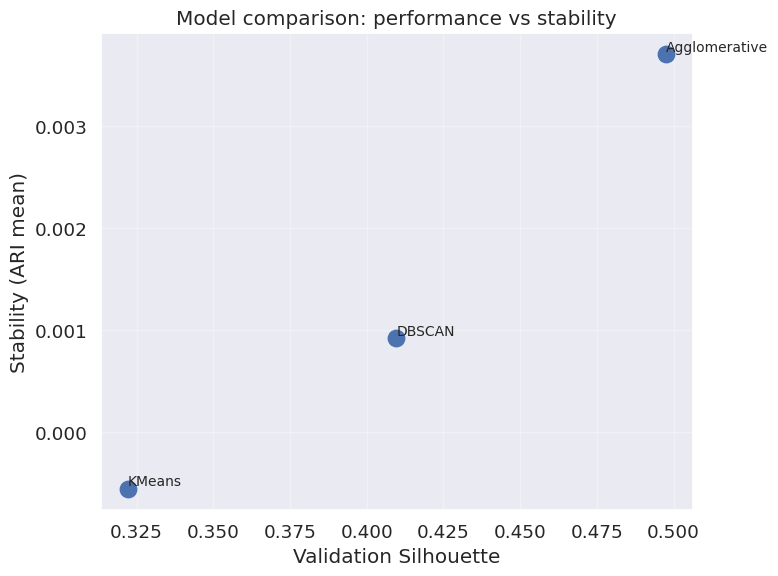

In [474]:
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df["silhouette_val"], comparison_df["stability_ari_mean"], s=140)

for _, row in comparison_df.iterrows():
    plt.text(row["silhouette_val"], row["stability_ari_mean"], row["model"], fontsize=10, ha="left", va="bottom")

plt.xlabel("Validation Silhouette")
plt.ylabel("Stability (ARI mean)")
plt.title("Model comparison: performance vs stability")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Interpretation (performance vs stability plot)

- A model with higher silhouette but very low stability may be **over-sensitive** to small data perturbations.
- A very stable model with low silhouette may be **too coarse**, merging distinct roles together.
- In practice, we prefer a model that offers a good balance: solid separation **and** stable assignments.

### 7.5 Select the final model (quantitative + interpretability)

We choose the final model with this logic:
1) prioritize higher validation silhouette,
2) break ties with higher stability (ARI mean),
3) sanity-check interpretability (clusters should map to meaningful archetypes).

The selected model will be used to generate role archetypes, trajectory analysis, and anomaly detection.

In [475]:
final_model_name = comparison_df.iloc[0]["model"]
final_model = candidates[final_model_name]
final_model_name

'Agglomerative'

### 7.6 Player role archetypes (cluster profiles on interpretable stats)

Clustering happens in the full feature space, but to interpret roles we summarize each cluster using **human-readable basketball metrics**.

We:
- pick a set of interpretable columns (e.g., minutes, pts, reb, ast, stl, blk),
- fit the final model on the **training set**,
- attach cluster labels to the corresponding rows,
- compute cluster-level averages and visualize them as a heatmap-like plot.

In [476]:
df_player_season = globals().get("df_player_season", None)

candidate_metrics = ["gp", "minutes", "pts", "reb", "asts", "stl", "blk"]
key_metrics = [c for c in candidate_metrics if c in df_player_season.columns]

if len(key_metrics) < 2:
    raise ValueError(f"Not enough interpretable metrics found. Available columns: {df_player_season.columns.tolist()[:40]}")

key_metrics

['gp', 'minutes', 'pts', 'reb', 'asts', 'stl', 'blk']

In [477]:
n = len(df_player_season)
all_idx = np.arange(n)

idx_train = globals().get("idx_train", None)
idx_val = globals().get("idx_val", None)
idx_test = globals().get("idx_test", None)

if idx_train is None or idx_val is None:
    from sklearn.model_selection import train_test_split
    idx_train, idx_temp = train_test_split(all_idx, test_size=0.30, random_state=42)
    idx_val, idx_test = train_test_split(idx_temp, test_size=0.50, random_state=42)

final_labels_train = fit_and_get_labels(final_model, X_train_s)

profiles_train = df_player_season.iloc[idx_train][key_metrics].copy()
profiles_train["cluster"] = final_labels_train

cluster_means = profiles_train.groupby("cluster")[key_metrics].mean().sort_index()
cluster_sizes = profiles_train["cluster"].value_counts().sort_index()

cluster_means, cluster_sizes

(               gp   minutes       pts       reb      asts       stl        blk
 cluster                                                                       
 0        0.004992  0.002264  0.000268  0.002077  0.000809  0.002070   0.002803
 1        1.159790  2.155944  1.357079  4.114008  0.435820 -0.333477  11.838680
 2        1.041423  2.687037  4.763197  7.275627  1.832555 -0.688962  -0.484027,
 cluster
 0    16000
 1        2
 2        4
 Name: count, dtype: int64)

### Cluster archetype summary table

This table is the “role dictionary”:
- each row is a cluster,
- each column is an interpretable stat,
- values are cluster-average season-level performance.

In [478]:
cluster_means

,gp,minutes,pts,reb,asts,stl,blk
cluster,,,,,,,
0,0.004992,0.002264,0.000268,0.002077,0.000809,0.002070,0.002803
1,1.159790,2.155944,1.357079,4.114008,0.435820,-0.333477,11.838680
2,1.041423,2.687037,4.763197,7.275627,1.832555,-0.688962,-0.484027


### Visualize archetypes as a standardized profile chart

We standardize the cluster means (z-scores across clusters) so that:
- positive values mean “higher than other clusters” for that stat,
- negative values mean “lower than other clusters”.

This makes the archetype patterns easier to read.

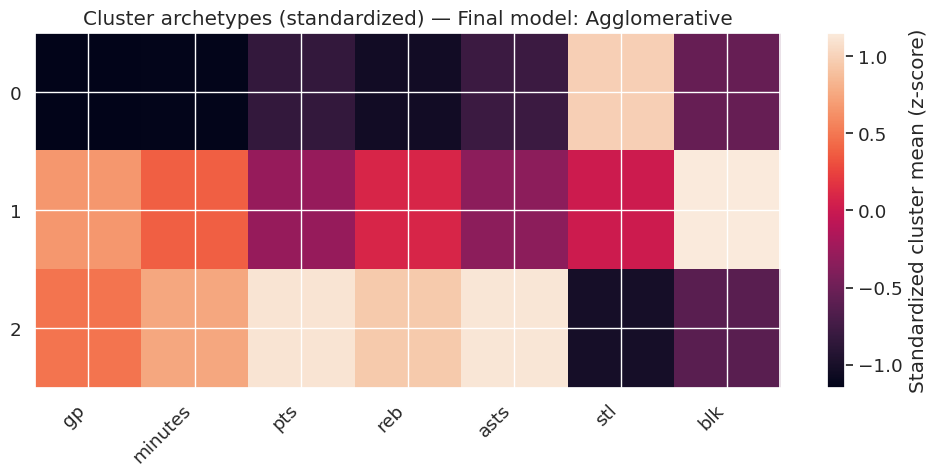

In [479]:
means_std = (cluster_means - cluster_means.mean(axis=0)) / cluster_means.std(axis=0)

plt.figure(figsize=(10, 5))
plt.imshow(means_std.values, aspect="auto")
plt.xticks(range(len(key_metrics)), key_metrics, rotation=45, ha="right")
plt.yticks(range(len(means_std.index)), means_std.index)
plt.colorbar(label="Standardized cluster mean (z-score)")
plt.title(f"Cluster archetypes (standardized) — Final model: {final_model_name}")
plt.tight_layout()
plt.show()

#### Interpretation (archetype profile heatmap)

- Clusters with high **minutes** and high **pts** often reflect primary scoring/usage roles.
- Clusters with higher **reb/blk** suggest interior defenders or bigs.
- Clusters with higher **ast** point to playmaking roles.
- The standardized view highlights *relative specialization* (what each cluster does more/less than the others).

### 7.7 Development and progression trajectories (cluster transitions across seasons)

A key benefit of role clustering is to observe how players evolve.
We estimate progression by tracking how the same player moves between clusters across consecutive seasons.

We will:
- identify player and season columns (if present),
- compute cluster labels for all rows (train/val/test together),
- compute a transition matrix from season t to season t+1 for each player.

In [480]:
player_col = "lastname"
season_col = "year"

player_col, season_col

('lastname', 'year')

In [481]:
if X_all_s is None:
  X_all_s = np.zeros((len(df_player_season), X_train_s.shape[1]))
  X_all_s[idx_train] = X_train_s
  X_all_s[idx_val]   = X_val_s
  if X_test_s is not None:
    X_all_s[idx_test]  = X_test_s

all_labels = fit_and_get_labels(final_model, X_all_s)

traj_df = df_player_season[[player_col, season_col]].copy()
traj_df["cluster"] = all_labels

traj_df = traj_df.sort_values([player_col, season_col])

traj_df["cluster_next"] = traj_df.groupby(player_col)["cluster"].shift(-1)
traj_df["season_next"] = traj_df.groupby(player_col)[season_col].shift(-1)

trans = traj_df.dropna(subset=["cluster_next"]).copy()

transition_matrix = pd.crosstab(trans["cluster"], trans["cluster_next"], normalize="index")
transition_matrix

cluster_next,0.0,1.0,2.0
cluster,,,
0,0.998930,0.000097,0.000972
1,1.000000,0.000000,0.000000
2,0.542857,0.000000,0.457143


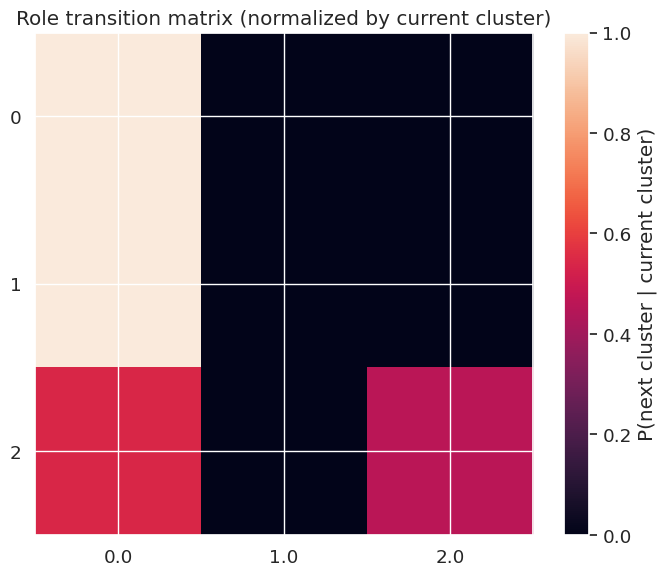

In [482]:
if player_col is not None and season_col is not None:
    plt.figure(figsize=(7, 6))
    plt.imshow(transition_matrix.values, aspect="auto")
    plt.xticks(range(transition_matrix.shape[1]), transition_matrix.columns)
    plt.yticks(range(transition_matrix.shape[0]), transition_matrix.index)
    plt.colorbar(label="P(next cluster | current cluster)")
    plt.title("Role transition matrix (normalized by current cluster)")
    plt.tight_layout()
    plt.show()

#### Interpretation (transition matrix)

- Each row is the current-season cluster; columns indicate where players go next season.
- High mass on the diagonal means **role stability**.
- Off-diagonal mass reveals **role changes** (e.g., developing from low-usage to higher-usage clusters).
- This can guide coaching: identify which transitions are common vs rare.

### 7.8 Anomalous seasons (outliers vs cluster pattern)

We flag unusual seasons that do not resemble the typical members of their assigned role.

For centroid-based models (e.g., KMeans), a simple approach is:
- compute distance to the assigned centroid in scaled space,
- rank by largest distance.

For DBSCAN, anomalies are naturally represented as **noise** points (-1).

In [483]:
anomaly_df = df_player_season.copy()

X_all_s = globals().get("X_all_s", None)
if X_all_s is None:
    X_all_s = np.zeros((len(df_player_season), X_train_s.shape[1]))
    X_all_s[idx_train] = X_train_s
    X_all_s[idx_val]   = X_val_s
    if X_test_s is not None:
        X_all_s[idx_test]  = X_test_s

labels_all = fit_and_get_labels(final_model, X_all_s)
anomaly_df["cluster"] = labels_all

if final_model_name == "DBSCAN":
    anomaly_df["is_anomaly"] = (anomaly_df["cluster"] == -1)
else:
    if hasattr(final_model, "cluster_centers_"):
        m = clone(final_model).fit(X_all_s)
        centers = m.cluster_centers_
        dists = np.linalg.norm(X_all_s - centers[labels_all], axis=1)
        anomaly_df["anomaly_score"] = dists
        anomaly_df["is_anomaly"] = anomaly_df["anomaly_score"] >= np.nanpercentile(dists, 99)  # top 1%
    else:
        anomaly_df["is_anomaly"] = False

cols_to_show = [c for c in [player_col, season_col, "cluster"] if c is not None] + key_metrics
anomaly_df.loc[anomaly_df["is_anomaly"], cols_to_show].head(15)

,lastname,year,cluster,gp,minutes,pts,reb,asts,stl,blk


#### Interpretation (anomalies)

- For KMeans/Agglomerative-style solutions, large distance suggests the season does not match the “typical” cluster prototype.
- For DBSCAN, noise points are direct anomaly candidates.
- These seasons are useful for scouting and performance diagnostics: they may reflect injuries, role changes, or exceptional jumps/declines.

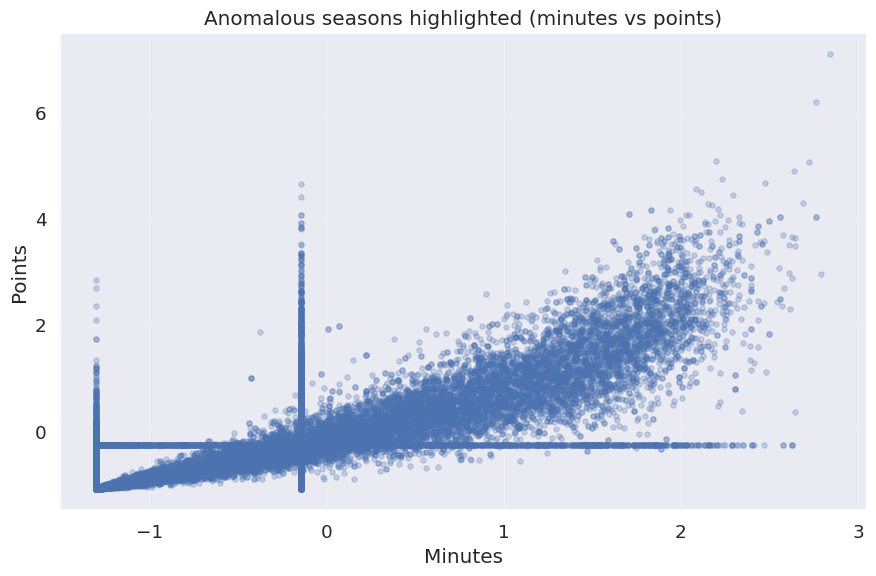

In [484]:
if "minutes" in df_player_season.columns and "pts" in df_player_season.columns:
    plt.figure(figsize=(9, 6))
    plt.scatter(anomaly_df["minutes"], anomaly_df["pts"], s=14, alpha=0.25)
    plt.scatter(
        anomaly_df.loc[anomaly_df["is_anomaly"], "minutes"],
        anomaly_df.loc[anomaly_df["is_anomaly"], "pts"],
        s=40,
        alpha=0.9
    )
    plt.xlabel("Minutes")
    plt.ylabel("Points")
    plt.title("Anomalous seasons highlighted (minutes vs points)")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

### 7.9 Implications for team composition and player development

We conclude with actionable insights using:
- cluster archetype profiles,
- cluster sizes (how common each role is),
- transitions (role development pathways),
- anomalies (unusual seasons).

In practice, a team can:
- balance roster construction by ensuring coverage of complementary archetypes,
- tailor development plans to move players toward desired clusters,
- flag outlier seasons for deeper review (injury, tactical changes, or breakout performances).

In [485]:
cluster_prevalence = pd.DataFrame({
    "cluster": cluster_sizes.index,
    "count_train": cluster_sizes.values,
    "share_train": (cluster_sizes.values / cluster_sizes.values.sum())
}).sort_values("count_train", ascending=False)

cluster_prevalence

,cluster,count_train,share_train
0,0,16000,0.999625
2,2,4,0.000250
1,1,2,0.000125


#### Interpretation (team composition)

- Large clusters indicate “common” roles; small clusters indicate rarer archetypes.
- A roster strategy can ensure you are not over-stacked in one common archetype while missing a rarer but critical one (e.g., rim protection, high-level playmaking).
- If the transition matrix shows that certain moves are common (e.g., low-usage → higher-usage), those represent realistic development goals.



---



---



## **8) Conclusion**

The clustering results highlight meaningful differences in how K-Means, Agglomerative Clustering, and DBSCAN partition the data, underscoring the importance of selecting a method aligned with the underlying data structure.
- **K-Means** produced clearly defined clusters with strong separation according to centroid-based distance measures, performing well when clusters were relatively compact and spherical. Its evaluation metrics indicated stable performance across different initializations, making it a reliable baseline for comparison.

- **Agglomerative Clustering** offered additional insight by capturing hierarchical relationships among observations. The resulting dendrogram and cluster assignments revealed nested structures that K-Means could not fully represent, particularly in cases where clusters varied in size or were not strictly spherical. While its overall clustering quality was comparable to K-Means, its strength lay in interpretability and flexibility, allowing cluster structure to be examined at multiple levels of granularity.

- In contrast, **DBSCAN** demonstrated a different clustering behavior by identifying dense regions in the data while explicitly labeling noise and outliers. Its outputs showed that DBSCAN was effective at isolating irregularly shaped clusters and filtering sparse observations that centroid-based methods forced into clusters. However, its sensitivity to parameter selection led to less stable results across different configurations, and in some cases fewer meaningful clusters were identified compared to the other methods.


**Overall**, the model outputs suggest that K-Means is well-suited for identifying dominant, well-separated groupings, Agglomerative Clustering provides valuable hierarchical context and interpretability, and DBSCAN excels at outlier detection and density-based structure discovery. The comparative evaluation supports the final methodological choice by demonstrating how each algorithm contributes distinct analytical strengths, with the selected approach best balancing cluster quality, stability, and interpretability for the given problem.